In [1]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.optimize import minimize, LinearConstraint, Bounds
from datetime import datetime
import docx
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Markovitz portfolio:

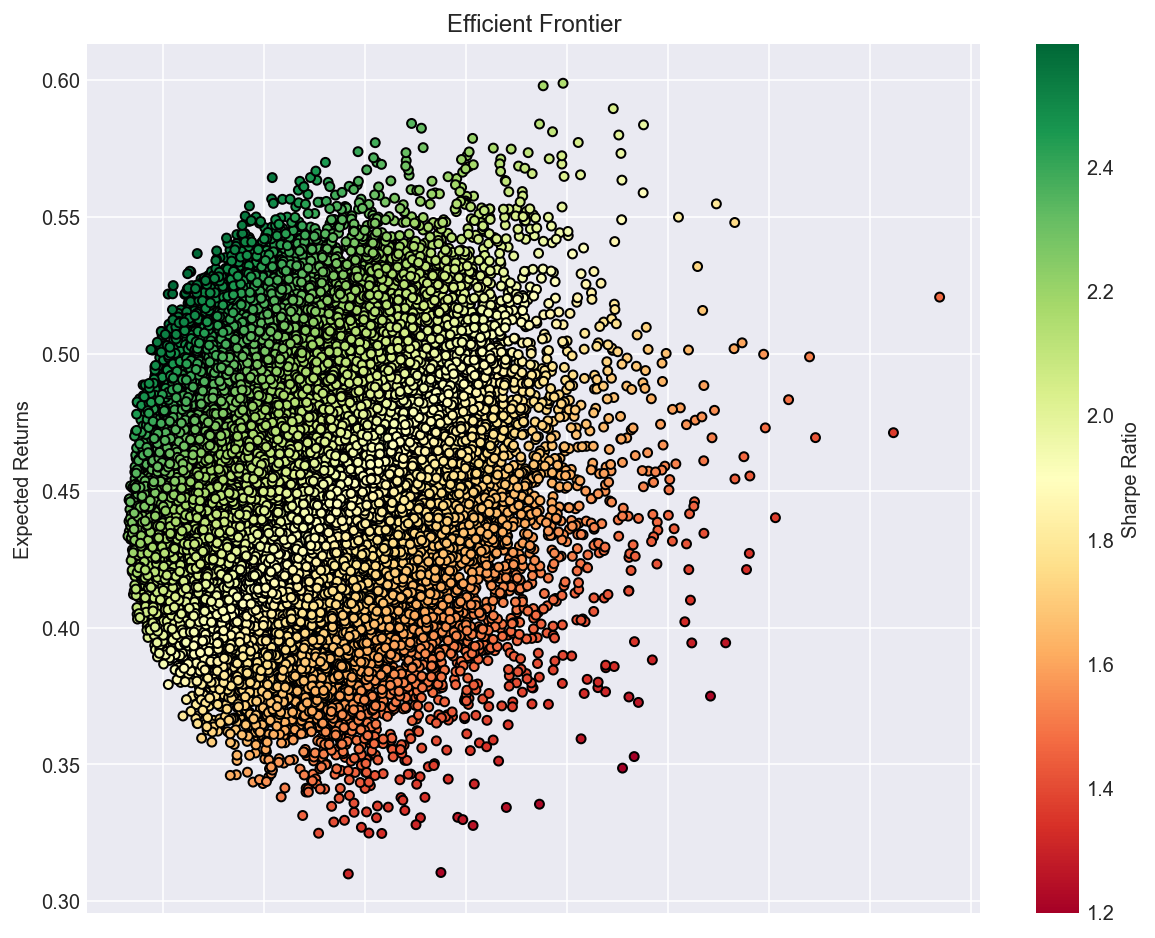

In [348]:
# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'Fefe7HWUcsAsoWBb7RrQ'
selected = ['AMZN', 'MPC', 'FANG', 'UNH', 'EQIX', 'GOOGL']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2013-12-31', 'lte': '2020-07-20' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
# returns_annual = [0.75, 0.35, 0.59, 0.31, 0.27, 0.23]
returns_annual = [((1 + np.mean(returns_daily.iloc[:, i])) ** 365 - 1) for i in range(len(selected))]
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 365 

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.savefig("./Pictures/portfolio_set.svg", dpi=1)
plt.show()

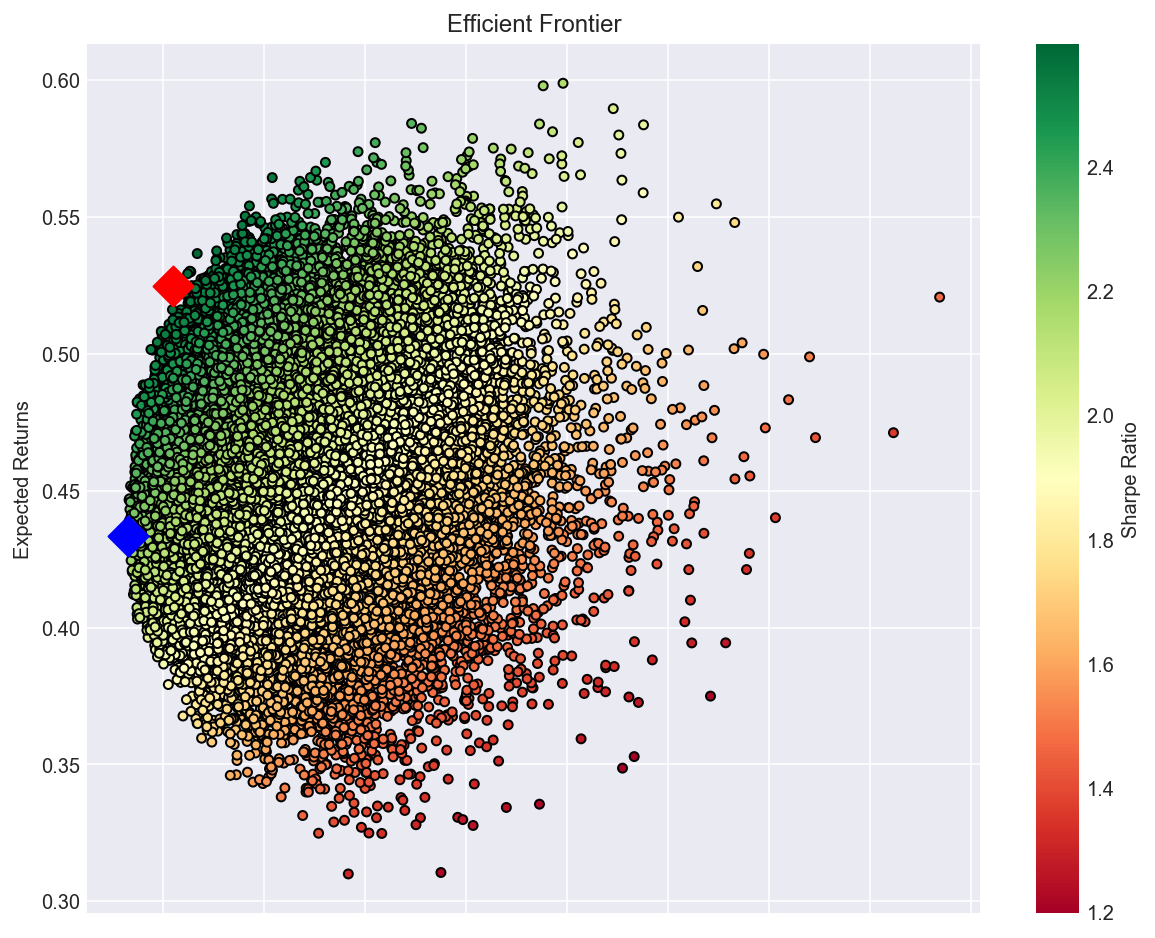

In [299]:

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [307]:

# open an existing document
doc = docx.Document('./for_tables.docx')

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(cov_annual.shape[0]+1, cov_annual.shape[1])

# add the header rows.
for j in range(cov_annual.shape[-1]):
    t.cell(0,j).text = cov_annual.columns[j]

# add the rest of the data frame
for i in range(cov_annual.shape[0]):
    for j in range(cov_annual.shape[-1]):
        t.cell(i+1,j).text = str(cov_annual.values[i,j])

# save the doc
doc.save('./for_tables.docx')

In [309]:
cov_annual

adj_close                                                  
ticker                AMZN      EQIX      FANG     GOOGL       MPC       UNH
          ticker                                                            
adj_close AMZN    0.126840  0.030940  0.038419  0.055265  0.039022  0.024449
          EQIX    0.030940  0.070573  0.019695  0.027093  0.029469  0.022070
          FANG    0.038419  0.019695  0.214071  0.029222  0.056455  0.025984
          GOOGL   0.055265  0.027093  0.029222  0.073413  0.036224  0.023760
          MPC     0.039022  0.029469  0.056455  0.036224  0.151184  0.029527
          UNH     0.024449  0.022070  0.025984  0.023760  0.029527  0.059085

In [312]:
min_variance_port.T

36375
Returns       0.433432
Volatility    0.193103
Sharpe Ratio  2.244570
AMZN Weight   0.044317
MPC Weight    0.259338
FANG Weight   0.057113
UNH Weight    0.247304
EQIX Weight   0.043874
GOOGL Weight  0.348054

In [313]:
sharpe_portfolio.T

32287
Returns       0.524966
Volatility    0.202062
Sharpe Ratio  2.598041
AMZN Weight   0.213842
MPC Weight    0.312604
FANG Weight   0.028705
UNH Weight    0.002556
EQIX Weight   0.009434
GOOGL Weight  0.432859

Сумма волатильностей, активов входящих в портфель инвестиций:

Сравнение с портфелем sharpe_ratio:

In [319]:
n1 = np.array([sharpe_portfolio.values[0][i] for i in range(3, 9)])

In [323]:
np.dot(n1.T, np.dot(cov_annual, n1))

0.040829211711694464

In [343]:
np.sqrt(np.sum((np.var(returns_daily) * 365) * n1))

0.28712676650819713

In [432]:
np.std(returns_daily, axis=0) ** 2

           ticker
adj_close  AMZN      0.000347
           EQIX      0.000193
           FANG      0.000586
           GOOGL     0.000201
           MPC       0.000414
           UNH       0.000162
dtype: float64

In [339]:
n_rep = np.repeat(1/6, 6)
np.sqrt(np.dot(n1.T, np.dot(cov_annual, n1)))

0.20206239559030884

Сравнение с портфелем min_variance_port:

In [316]:
n2 = np.array([min_variance_port.values[0][i] for i in [3, 7, 5, 8, 4, 6]])

In [317]:
sum(np.array([cov_annual.iloc[i, i] ** 0.5 for i in range(6)]) * n2)

0.30911847256356323

In [318]:
cov_annual

adj_close                                                  
ticker                AMZN      EQIX      FANG     GOOGL       MPC       UNH
          ticker                                                            
adj_close AMZN    0.126840  0.030940  0.038419  0.055265  0.039022  0.024449
          EQIX    0.030940  0.070573  0.019695  0.027093  0.029469  0.022070
          FANG    0.038419  0.019695  0.214071  0.029222  0.056455  0.025984
          GOOGL   0.055265  0.027093  0.029222  0.073413  0.036224  0.023760
          MPC     0.039022  0.029469  0.056455  0.036224  0.151184  0.029527
          UNH     0.024449  0.022070  0.025984  0.023760  0.029527  0.059085

# Stochastic Mean-Variance portfolio:

In [ ]:
quandl.ApiConfig.api_key = 'Fefe7HWUcsAsoWBb7RrQ'
selected = ['AMZN', 'MPC', 'FANG', 'UNH', 'EQIX', 'GOOGL']
data = quandl.get_table('NASDAQOMX/XQC', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2010-1-1', 'lte': '2020-06-27' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.dropna(inplace=True)

In [ ]:
len(table)

In [ ]:
table.to_csv('data_stocks.csv')

## MGARCH in R:

Transforming data frame:

In [ ]:
df <- data.frame(read.csv('data_stocks.csv', header=F))

In [ ]:
colnames(df) <- c('date', 'AMZN', 'MPC', 'FANG', 'UNH', 'EQIX', 'GOOGL')
df <- df[4:dim(df)[1],]

In [ ]:
head(df)

### Yfinance

In [ ]:
import yfinance as yf

data = yf.download("AMZN MPC FANG UNH EQIX GOOGL ^FVX", start="2014-01-01", end="2020-07-03", interval = '1d')

In [ ]:
data

In [ ]:
data.Close['AMZN'].plot()

In [ ]:
data['Close'].to_csv('data_stocks.csv')

## Stochastic programming

### Reading JSON adn CSV data files.

In [2]:
from pprint import pprint

In [3]:
with open('set_sim_mean.json', 'r') as json_file:
    json_mean = json.load(json_file)

In [4]:
with open('df_test.json', 'r') as json_file:
    json_df_test = json.load(json_file)

In [5]:
real_return = []
for i in range(len(json_df_test)):
    real_return.append(np.array(list(json_df_test[i].values())[1:]))

In [6]:
with open('set_sim_covar.json', 'r') as json_file:
    json_covar = json.load(json_file)

In [7]:
# Transforming json_covar into list of data.frames.
names = list(json_covar[1].values())[-1]
size = len(json_mean[0])
list_covar = list()
l = len(list(json_covar[0].values())[0])  - 1
for i in range(len(json_covar)):
    dt = pd.DataFrame(np.zeros((size, size)), columns=names, index=names)
    for n in range(l):
         dt.iloc[n, ] = list(json_covar[i].values())[n]
    list_covar.append(dt)    

In [8]:
dates = pd.to_datetime([i['Date'] for i in json_df_test])

In [11]:
with open("set_montecarlo_mean.json", 'r') as json_file:
    json_montecarlo_mean = json.load(json_file)

In [12]:
# Transformin json_montecarlo_mean into list of lists.
montecarlo_mean = list()
for i in range(len(json_montecarlo_mean)):
    list_of_means = list()
    for j in range(len(json_montecarlo_mean[0])):
        list_of_means.append(list(json_montecarlo_mean[i][j].values()))
    montecarlo_mean.append(list_of_means)

In [13]:
montecarlo_mean[0][5]

[-0.0426453, -0.0176401, -0.0152381, -0.0190765, -0.0291129, 0.0046883]

In [14]:
with open("set_montecarlo_covar.json", 'r') as json_file:
    json_montecarlo_covar = json.load(json_file)

In [15]:
# Transforming json_montecarlo_covar into list of data.table.
# (json_montecarlo_covar[0][0])
names = list(json_covar[1].values())[-1]
size = len(json_montecarlo_covar[0][0])
montecarlo_covar = list()
for i in range(len(json_montecarlo_covar)):
    list_of_sim = list()
    for j in range(len(json_montecarlo_covar[0])):
        dt = pd.DataFrame(np.zeros((size, size)), columns=names, index=names)
        for n in range(len(json_montecarlo_covar[i][j])):
            dt.iloc[n, ] = json_montecarlo_covar[i][j][n]
        list_of_sim.append(dt)
    montecarlo_covar.append(list_of_sim)

In [16]:
len(json_montecarlo_covar)

328

In [17]:
# Reading risk free rate 3 month Bill return.
data_risk_free = pd.read_csv('DTB3_data.csv', header=0, sep=',')
data_risk_free.loc[:,'DATE'] = pd.to_datetime(data_risk_free.loc[:,"DATE"])

# Dealing with NA values:
na_indices = list(data_risk_free.loc[data_risk_free.loc[:, "DTB3"] == '.'].index)

for i in na_indices:
    data_risk_free.iloc[i, 1] = data_risk_free.iloc[i - 1, 1]

data_risk_free.iloc[:, 1] = data_risk_free.iloc[:,1].values.astype(np.float32)

In [363]:
json1 = list(json_covar[1].values())
covar1 = pd.DataFrame(json1[:-1], index = json1[-1], columns = json1[-1])
covar1

AMZN      EQIX      FANG     GOOGL       MPC       UNH
AMZN   0.000244  0.000057  0.000161  0.000148  0.000147  0.000119
EQIX   0.000057  0.000208  0.000052  0.000050  0.000055  0.000078
FANG   0.000161  0.000052  0.000581  0.000138  0.000241  0.000148
GOOGL  0.000148  0.000050  0.000138  0.000189  0.000132  0.000121
MPC    0.000147  0.000055  0.000241  0.000132  0.000436  0.000165
UNH    0.000119  0.000078  0.000148  0.000121  0.000165  0.000358

In [364]:
mean1 = np.array(list(json_mean[1].values()))
mean1

array([ 3.1780e-03,  7.4770e-04,  1.4510e-04,  1.4065e-03, -3.6600e-05,
        1.2927e-03])

In [365]:
covar1.values

array([[2.436e-04, 5.670e-05, 1.607e-04, 1.476e-04, 1.474e-04, 1.187e-04],
       [5.670e-05, 2.075e-04, 5.170e-05, 4.990e-05, 5.540e-05, 7.790e-05],
       [1.607e-04, 5.170e-05, 5.814e-04, 1.382e-04, 2.409e-04, 1.478e-04],
       [1.476e-04, 4.990e-05, 1.382e-04, 1.885e-04, 1.320e-04, 1.209e-04],
       [1.474e-04, 5.540e-05, 2.409e-04, 1.320e-04, 4.356e-04, 1.648e-04],
       [1.187e-04, 7.790e-05, 1.478e-04, 1.209e-04, 1.648e-04, 3.579e-04]])

In [366]:
covar1

AMZN      EQIX      FANG     GOOGL       MPC       UNH
AMZN   0.000244  0.000057  0.000161  0.000148  0.000147  0.000119
EQIX   0.000057  0.000208  0.000052  0.000050  0.000055  0.000078
FANG   0.000161  0.000052  0.000581  0.000138  0.000241  0.000148
GOOGL  0.000148  0.000050  0.000138  0.000189  0.000132  0.000121
MPC    0.000147  0.000055  0.000241  0.000132  0.000436  0.000165
UNH    0.000119  0.000078  0.000148  0.000121  0.000165  0.000358

## Mean-Variance portfolio without risk-free asset.

### Optimization task:

$$\underset{w_n}{Minimize} \frac{c}{2}w_n^T \Sigma w_n - w_n^T \mu_n + \phi(w_n - w_{n-1})$$
s.t.$$1^T(w_n - w_{n-1}) + \phi(w_n - w_{n-1}) \leq 0 $$
where 
$$ \phi_i(x_i) = \left\{\begin{aligned} & = \alpha_i^+ x_i,  x \geq 0\\ & = - \alpha_i^- x_i,  x \leq 0  \end{aligned}\right.$$

In [18]:
# w = np.repeat(1, covar1.shape[1])
a = 0.0015

In [19]:
# Cost function.
def fi(x, a=0.0015):
    ans = list()
    for i in x:
        if i >= 0:
            ans.append(a * i) 
        else:
            ans.append(-a * i)
    return(sum(np.array(ans)))

In [20]:
def obj_func(w, w0, covar, mean, c):
    return (c/2 * np.dot(np.dot(w.T, covar), w) - np.dot(w.T, mean) + fi(w - w0))

In [21]:
def con(w, w0):
    unity_vector = np.repeat(1, len(w))
    return (-(np.dot(unity_vector.T, w - w0) + fi(w - w0)))
             

In [22]:
def con_init(w):
    return (np.sum(w) - 1)

constraints_init = {'type': 'eq', 'fun': con_init}

In [23]:
def obj_func_init(w, covar, mean, c):
    return (c/2 * np.dot(np.dot(w.T, covar), w) - np.dot(w.T, mean) + fi(w))

In [24]:
%%time
res_list = []
c = 1
for i in range(len(json_mean)):
    json1_covar = list(json_covar[i].values())
    covar1 = pd.DataFrame(json1_covar[:-1], index = json1_covar[-1], columns = json1_covar[-1])
    mean1 = np.array(list(json_mean[i].values()))
    
    if i == 0:
        w = np.array([.1, .1, .1, .1, .1, .1])
        constraints_init = {'type': 'eq', 'fun': con_init}
        res_list.append(minimize(obj_func_init, w, args = (covar1, mean1, c), method="SLSQP", constraints=constraints_init, bounds=Bounds(0, 1)).x)
    else:
        w = np.array([.1, .1, .1, .1, .1, .1])
        w0 = res_list[i - 1]
        constraints = {'type': 'ineq', 'fun': con, 'args': [w0]}
        constraints_init = {'type': 'eq', 'fun': con_init}
        res_list.append(minimize(obj_func, w, args = (w0, covar1, mean1, c), method="SLSQP", constraints=list([constraints, constraints_init]), bounds=Bounds(0, 1)).x)

CPU times: user 1.63 s, sys: 19.9 ms, total: 1.65 s
Wall time: 1.69 s


In [448]:
np.sum(res_list[-1])

1.0000000000000009

In [449]:
type(res_list[0])

numpy.ndarray

### Benchmarking.

### Daily returns. 

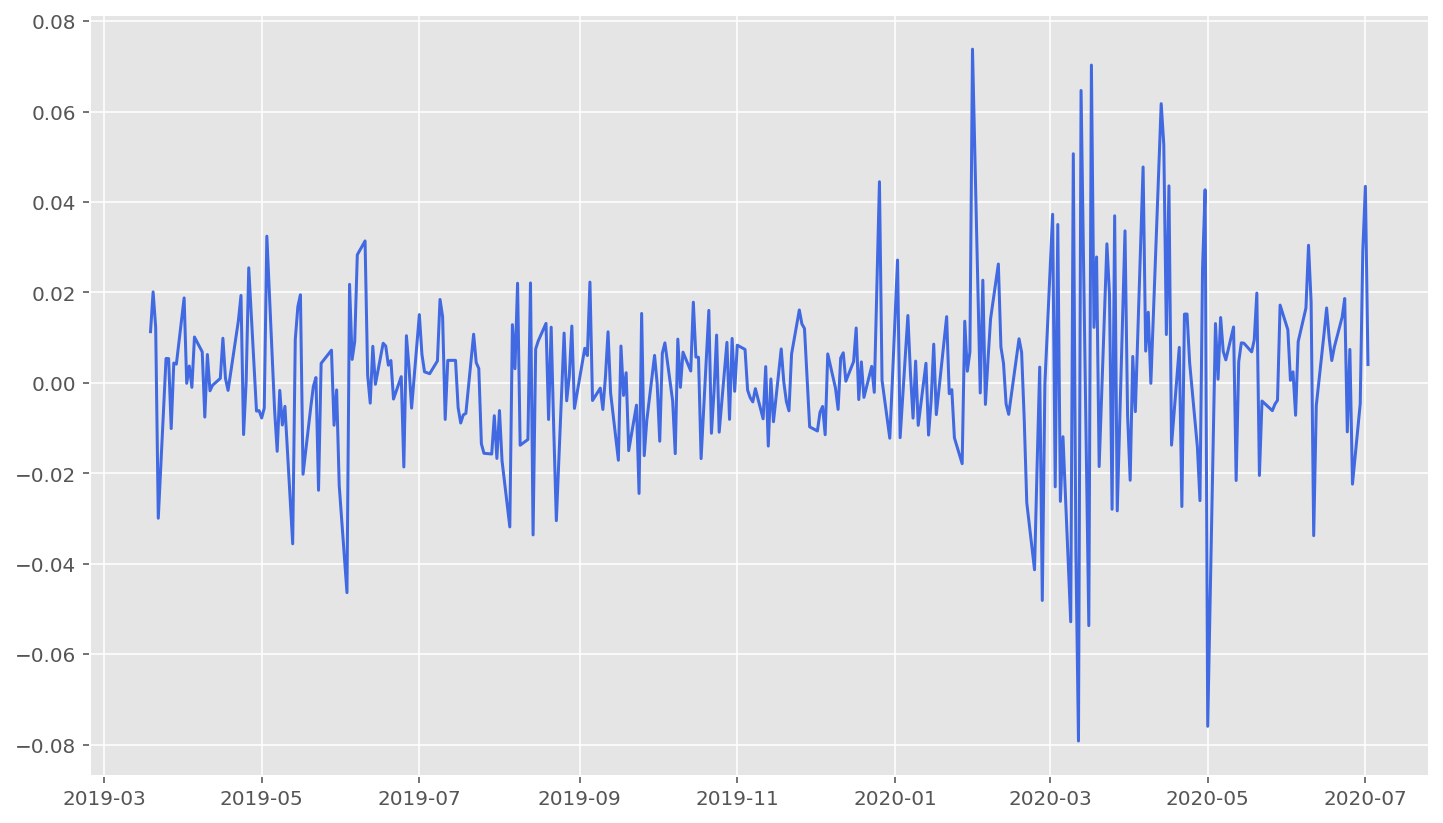

In [25]:
# Daily realized returns per each asset.
def return_daily(real_return, res_list):

    return_daily = list()
    # Daily portfolio anualized realized returns.
    for i in range(len(real_return)):
        return_daily.append(np.dot(real_return[i], np.array(res_list[i]).T))
    
    return return_daily

plt.style.use('ggplot')
plt.figure(figsize=(12,7))
plt.plot_date(dates, return_daily(real_return, res_list), '-', color='royalblue')
plt.show()

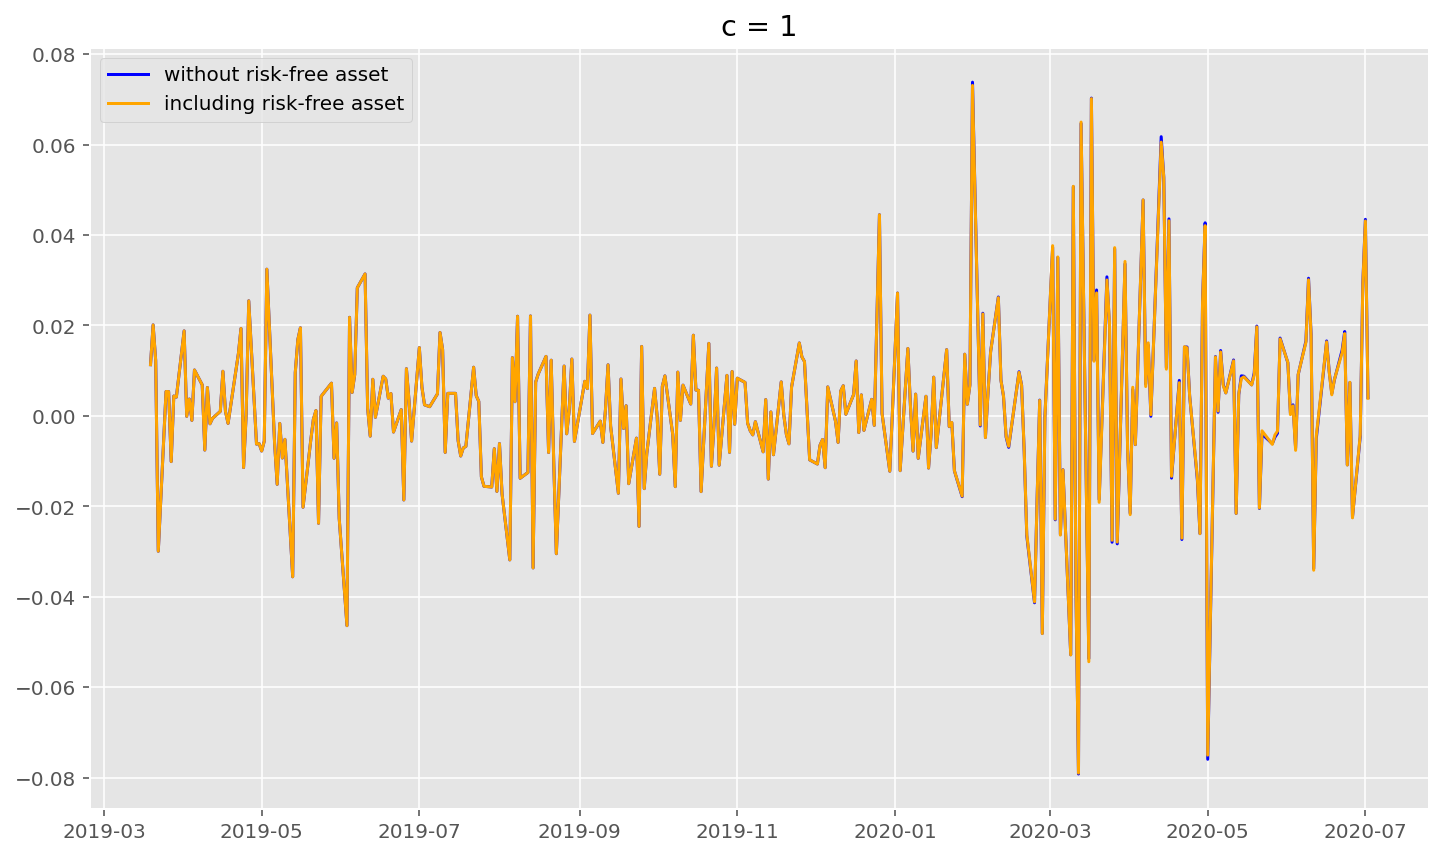

In [38]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
ax.plot_date(dates, return_daily(real_return, res_list), '-', color='blue', label = 'without risk-free asset')
ax.plot_date(dates, return_daily(return_with_rf, res_list2), '-', color='orange', label = 'including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 1')
plt.show()

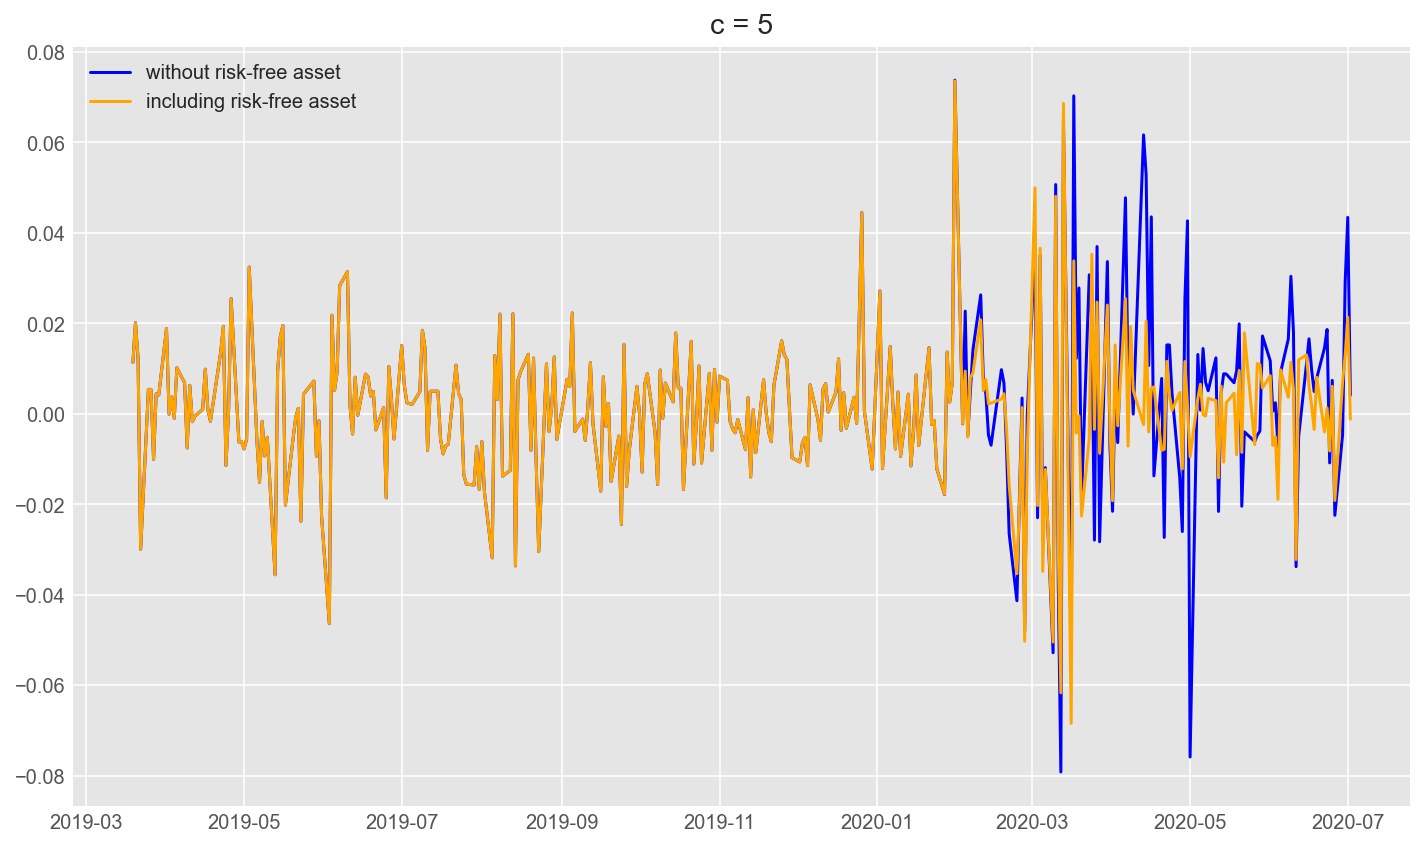

In [560]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
ax.plot_date(dates, return_daily(real_return, res_list), '-', color='blue', label = 'without risk-free asset')
ax.plot_date(dates, return_daily(return_with_rf, res_list2), '-', color='orange', label = 'including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 5')
plt.show()

### Graph of cumulative returns. 

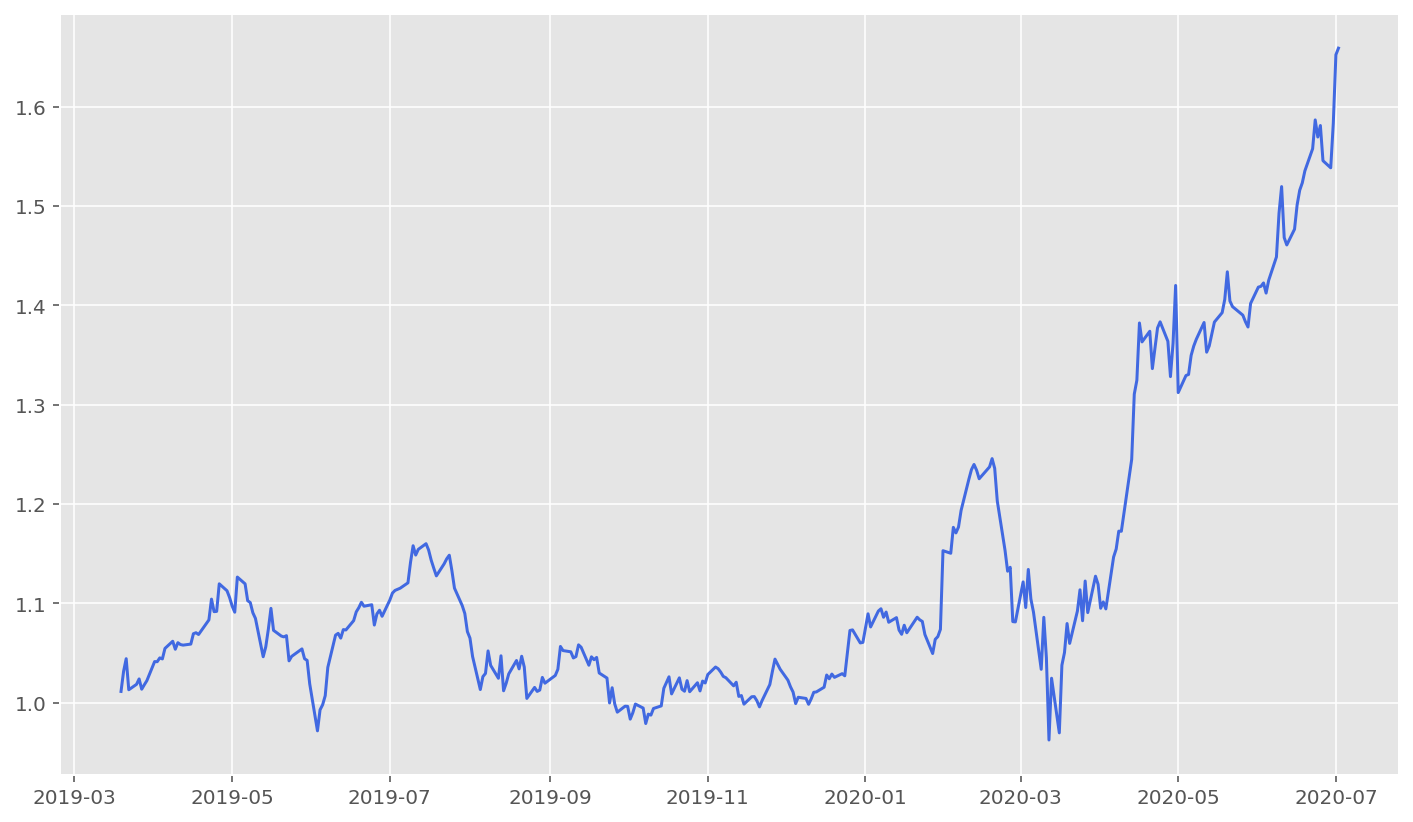

In [39]:
def plot_cumulative(real_return, res_list):
    return_d = return_daily(real_return, res_list)
    cumulative_returns = [1 + return_d[0]]
    for i in range(1, len(return_d)):
        cumulative_returns.append((1 + return_d[i]) * cumulative_returns[i - 1])

    plt.style.use('ggplot')
    plt.figure(figsize=(12,7))
    plt.plot_date(dates, cumulative_returns, '-', color='royalblue')
    plt.show()
    
plot_cumulative(real_return, res_list)

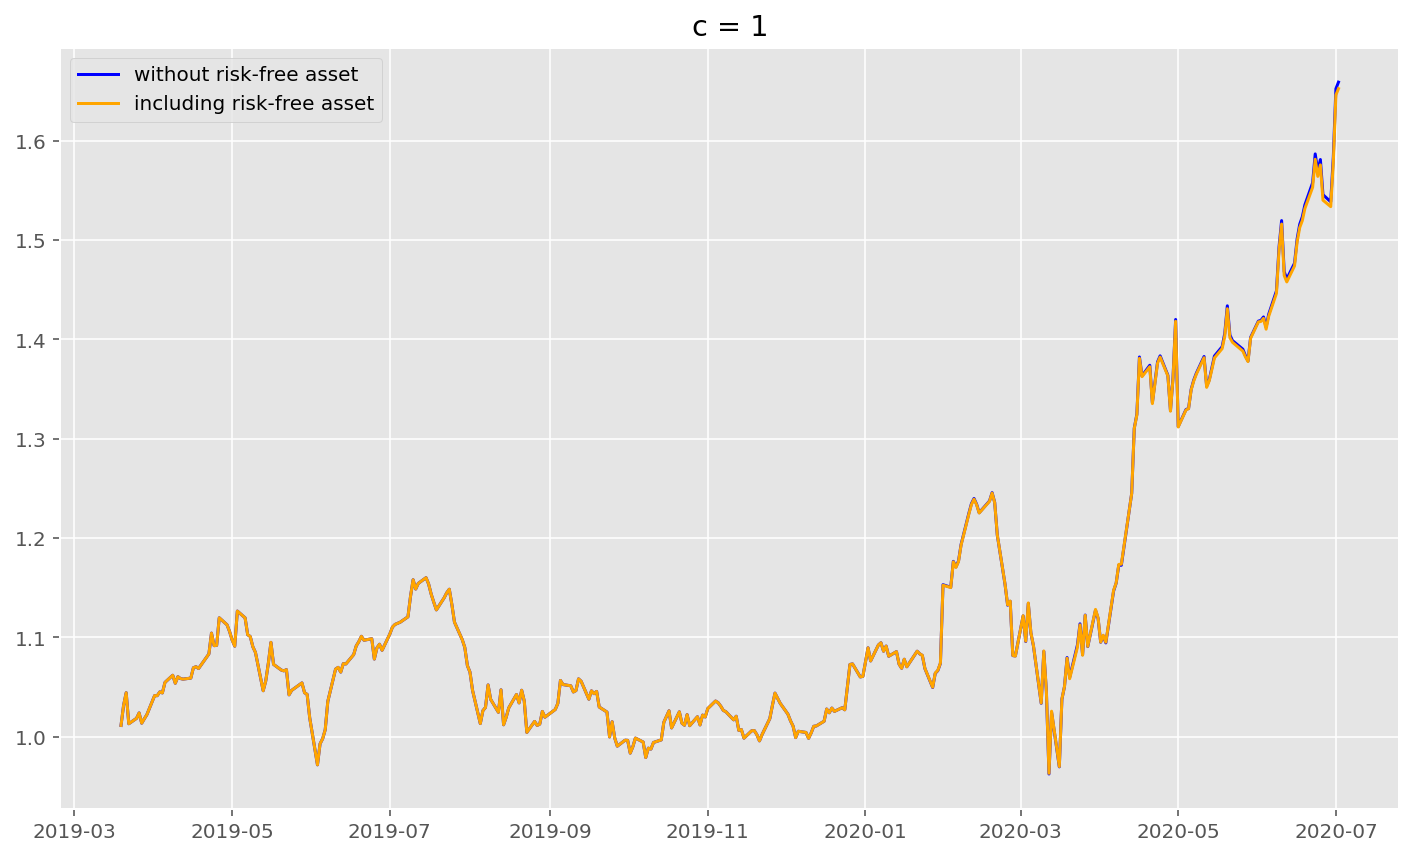

In [40]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')

return_d1 = return_daily(real_return, res_list)
cumulative_returns1 = [1 + return_d1[0]]
for i in range(1, len(return_d1)):
    cumulative_returns1.append((1 + return_d1[i]) * cumulative_returns1[i - 1])

return_d2 = return_daily(return_with_rf, res_list2)
cumulative_returns2 = [1 + return_d2[0]]
for i in range(1, len(return_d2)):
    cumulative_returns2.append((1 + return_d2[i]) * cumulative_returns2[i - 1])
    


ax.plot_date(dates, cumulative_returns1, '-', color='blue', label = 'without risk-free asset')
ax.plot_date(dates, cumulative_returns2, '-', color='orange', label = 'including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 1')
plt.show()

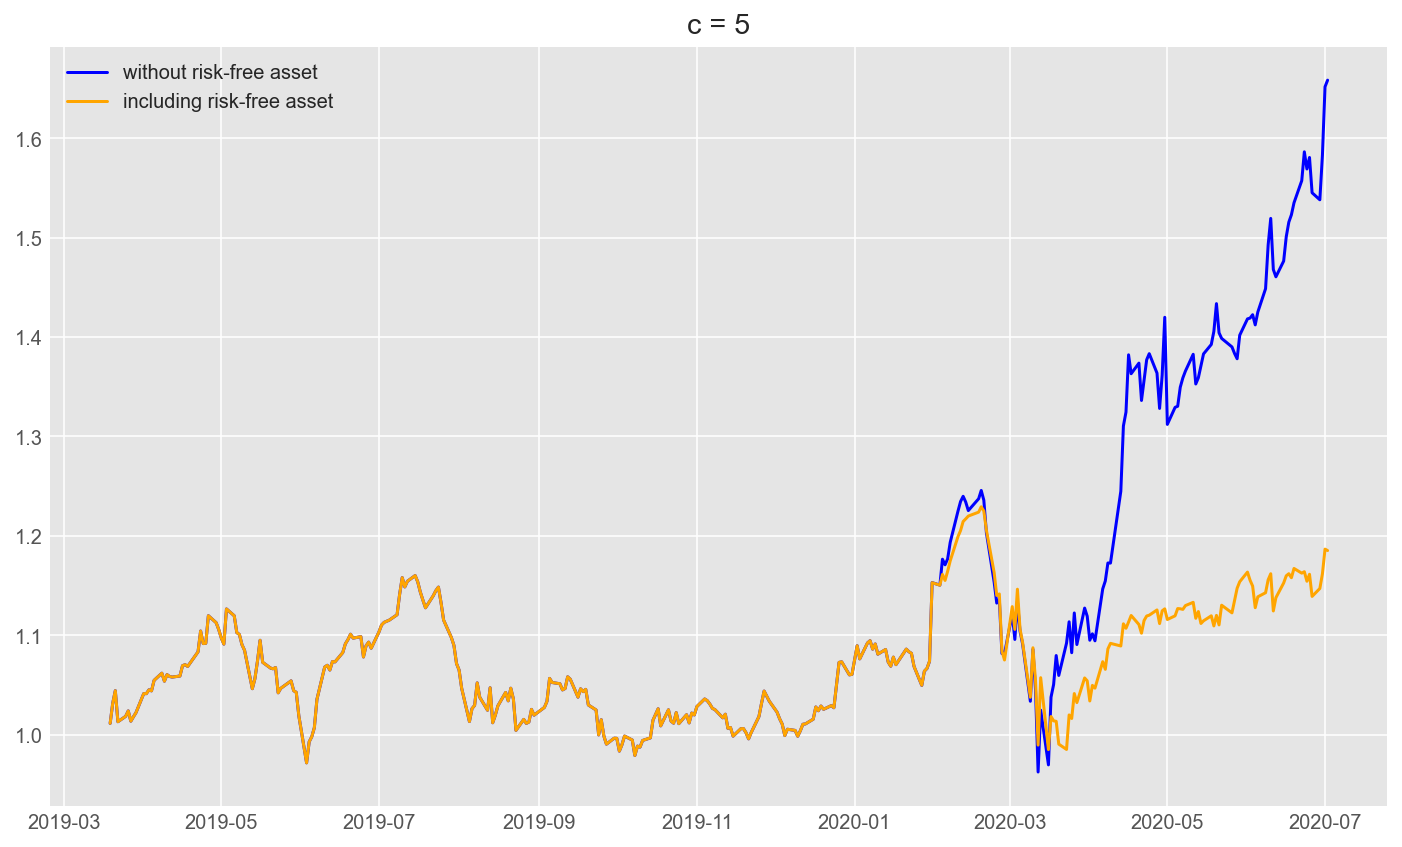

In [561]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')

return_d1 = return_daily(real_return, res_list)
cumulative_returns1 = [1 + return_d1[0]]
for i in range(1, len(return_d1)):
    cumulative_returns1.append((1 + return_d1[i]) * cumulative_returns1[i - 1])

return_d2 = return_daily(return_with_rf, res_list2)
cumulative_returns2 = [1 + return_d2[0]]
for i in range(1, len(return_d2)):
    cumulative_returns2.append((1 + return_d2[i]) * cumulative_returns2[i - 1])
    


ax.plot_date(dates, cumulative_returns1, '-', color='blue', label = 'without risk-free asset')
ax.plot_date(dates, cumulative_returns2, '-', color='orange', label = 'including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 5')
plt.show()

### Graph of ex ante portfolio variance

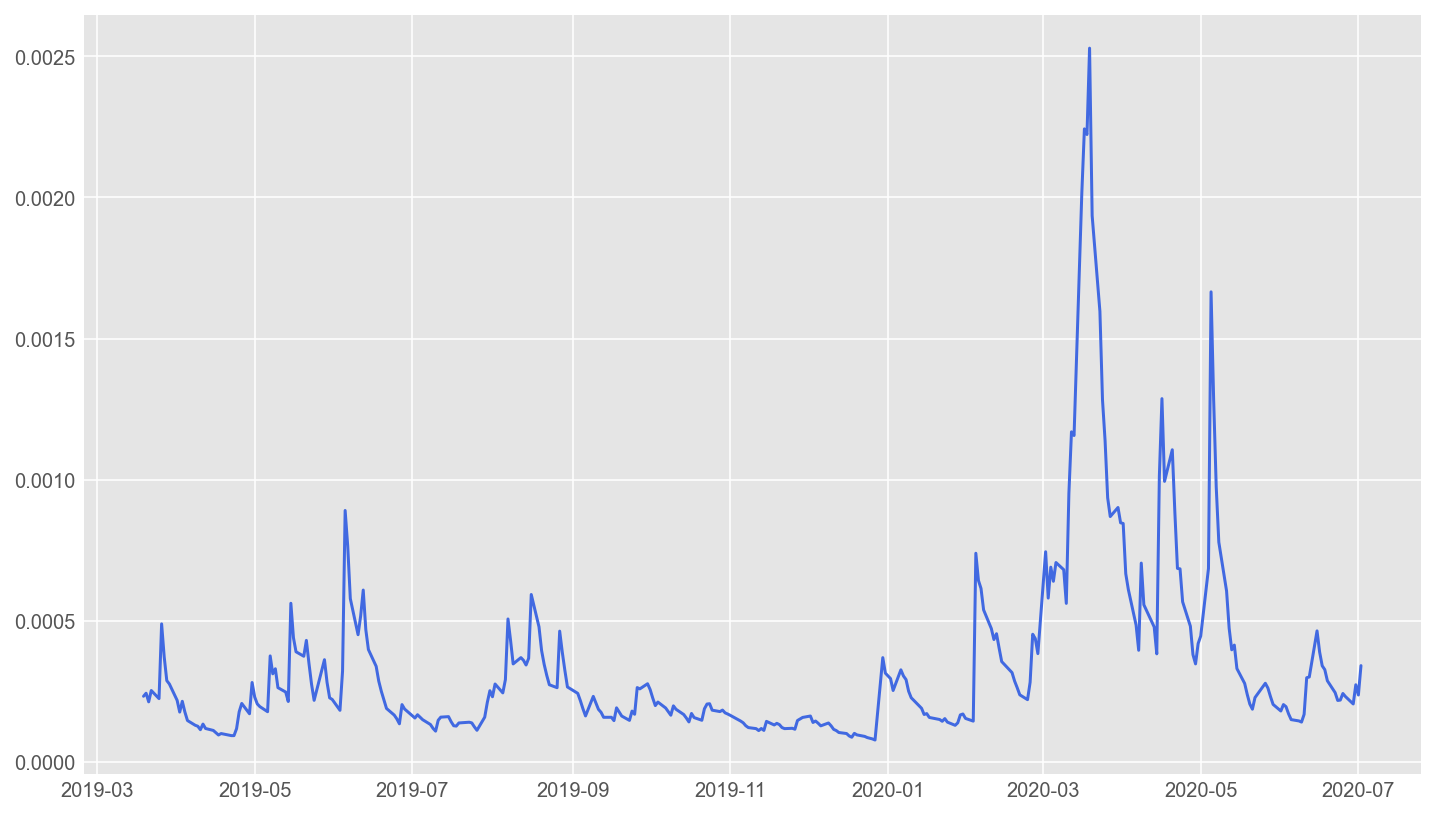

In [510]:
def plot_vol(list_covar, res_list):
    list_vol = list()
    for i in range(len(list_covar)):
        w = np.array(res_list[i])
        list_vol.append(np.dot(np.dot(w.T, list_covar[i].values), w))
    plt.style.use('ggplot')
    plt.figure(figsize=(12,7))
    plt.plot_date(dates, list_vol, '-', color='royalblue')
    plt.show()

plot_vol(list_covar[:-1], res_list)

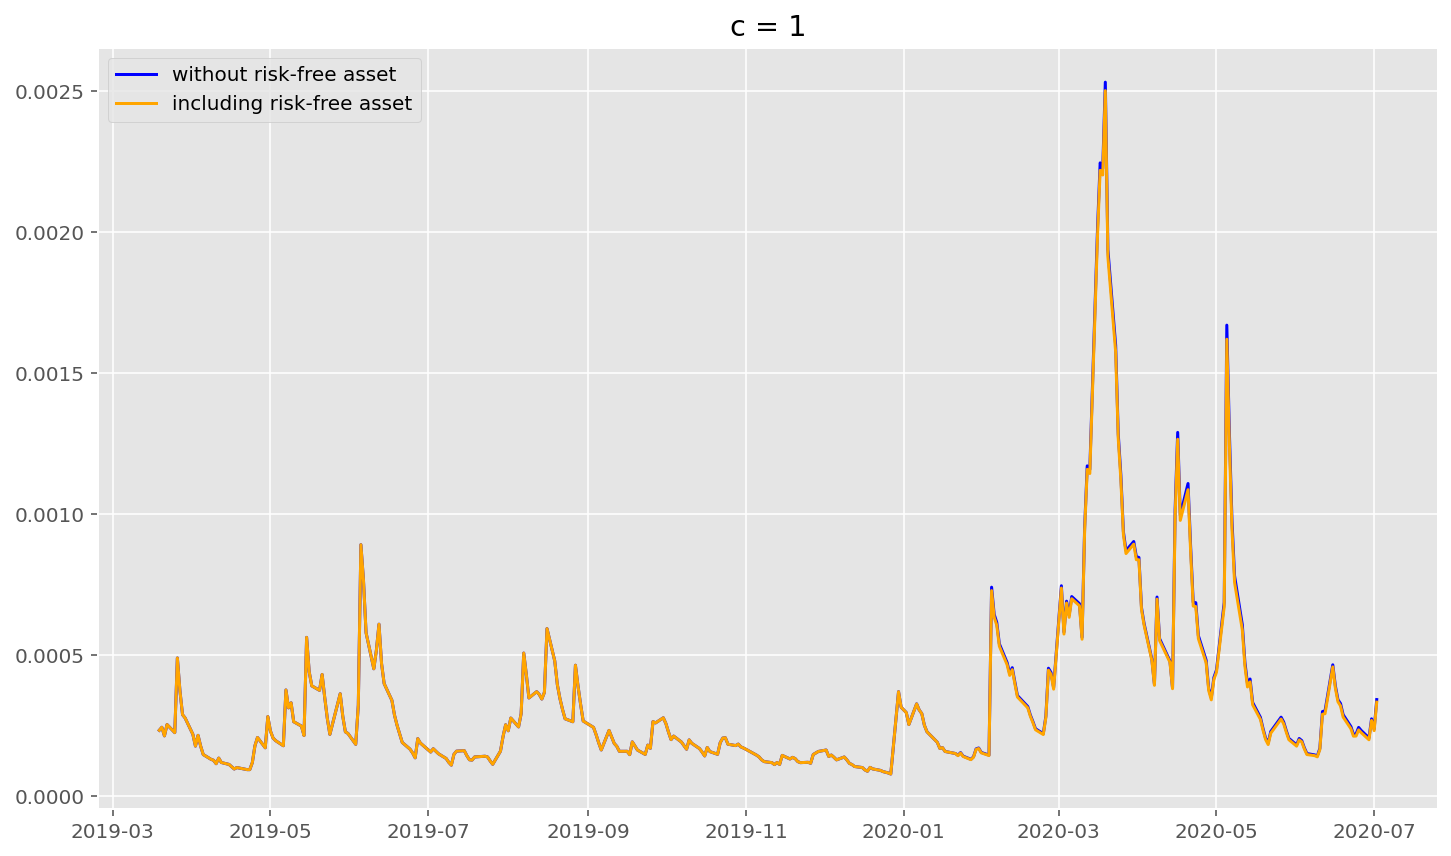

In [41]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')

list_vol1 = list()
for i in range(len(list_covar)):
    w = np.array(res_list[i])
    list_vol1.append(np.dot(np.dot(w.T, list_covar[i].values), w))
    
    
list_vol2 = list()
for i in range(len(list_covar[:-1])):
    w = np.array(([i[:-1] for i in res_list2])[i])
    list_vol2.append(np.dot(np.dot(w.T, list_covar[:-1][i].values), w))
    
    
ax.plot_date(dates, list_vol1[:-1], '-', color='blue', label='without risk-free asset')
ax.plot_date(dates, list_vol2, '-', color='orange', label='including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 1')
plt.show()

# plot_vol(list_covar[:-1], [i[:-1] for i in res_list2])

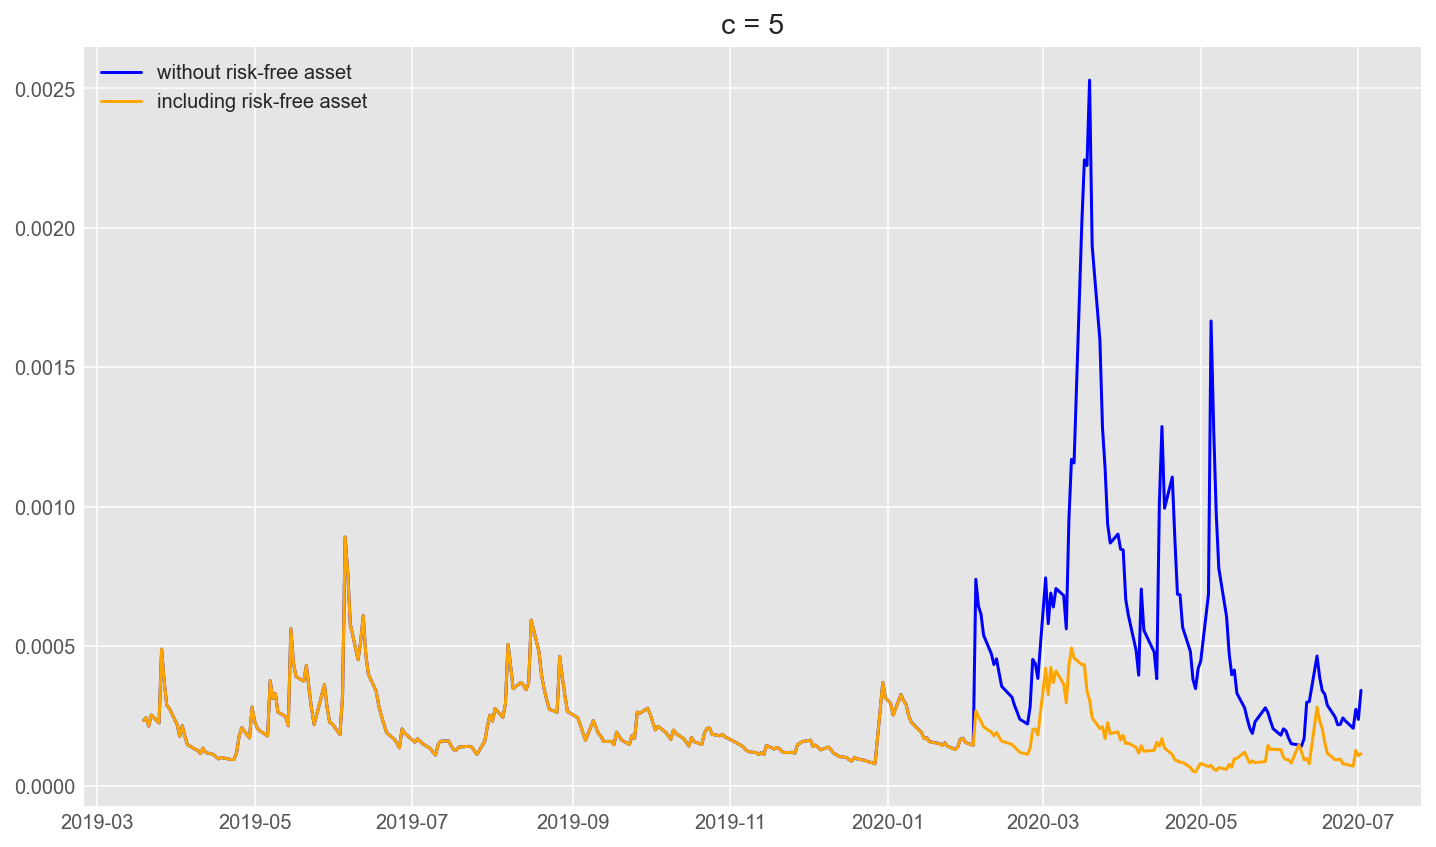

In [562]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')

list_vol1 = list()
for i in range(len(list_covar)):
    w = np.array(res_list[i])
    list_vol1.append(np.dot(np.dot(w.T, list_covar[i].values), w))
    
    
list_vol2 = list()
for i in range(len(list_covar[:-1])):
    w = np.array(([i[:-1] for i in res_list2])[i])
    list_vol2.append(np.dot(np.dot(w.T, list_covar[:-1][i].values), w))
    
    
ax.plot_date(dates, list_vol1[:-1], '-', color='blue', label='without risk-free asset')
ax.plot_date(dates, list_vol2, '-', color='orange', label='including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 5')
plt.show()

# plot_vol(list_covar[:-1], [i[:-1] for i in res_list2])

In [519]:
len(dates)

327

### Graph of ex ante Sharpe ratio

$$SR = \frac{E[R_p^A - r_f^A]}{\sigma_p^A}$$

In [27]:
equal_indices = [n in dates.values for n in data_risk_free.loc[:,"DATE"].values ]
risk_free = data_risk_free.loc[equal_indices,:]
risk_free.reset_index(drop=True, inplace=True)

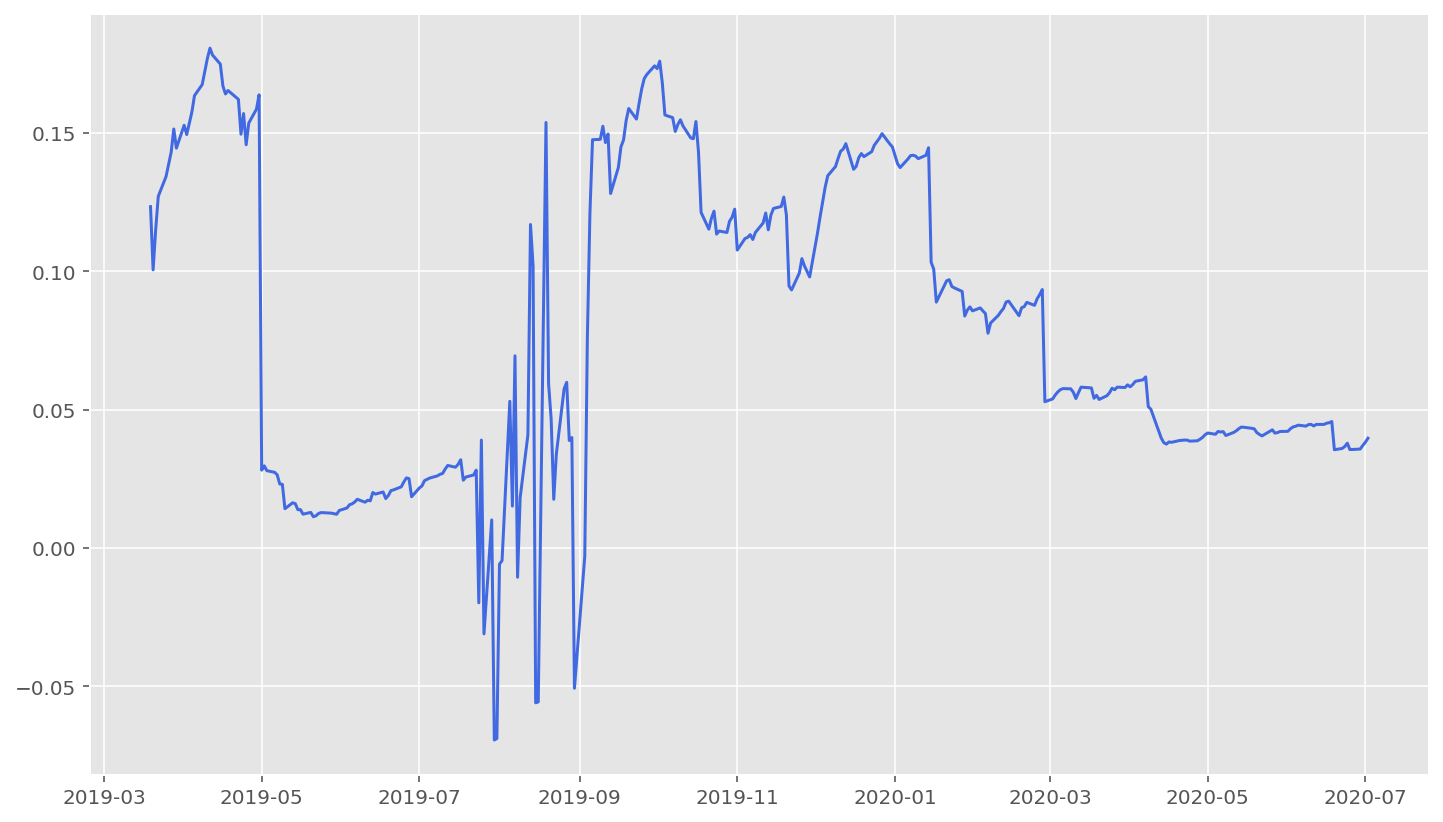

In [28]:
list_sr = list()
for i in range(len(risk_free)):
    sr = np.mean([np.dot(n, np.array(res_list[:-1][i])).T for n in np.array(montecarlo_mean[:-1][i])]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean[:-1][i])
    list_sr.append(sr)
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
plt.plot_date(dates, list_sr, '-', color='royalblue')
plt.show()

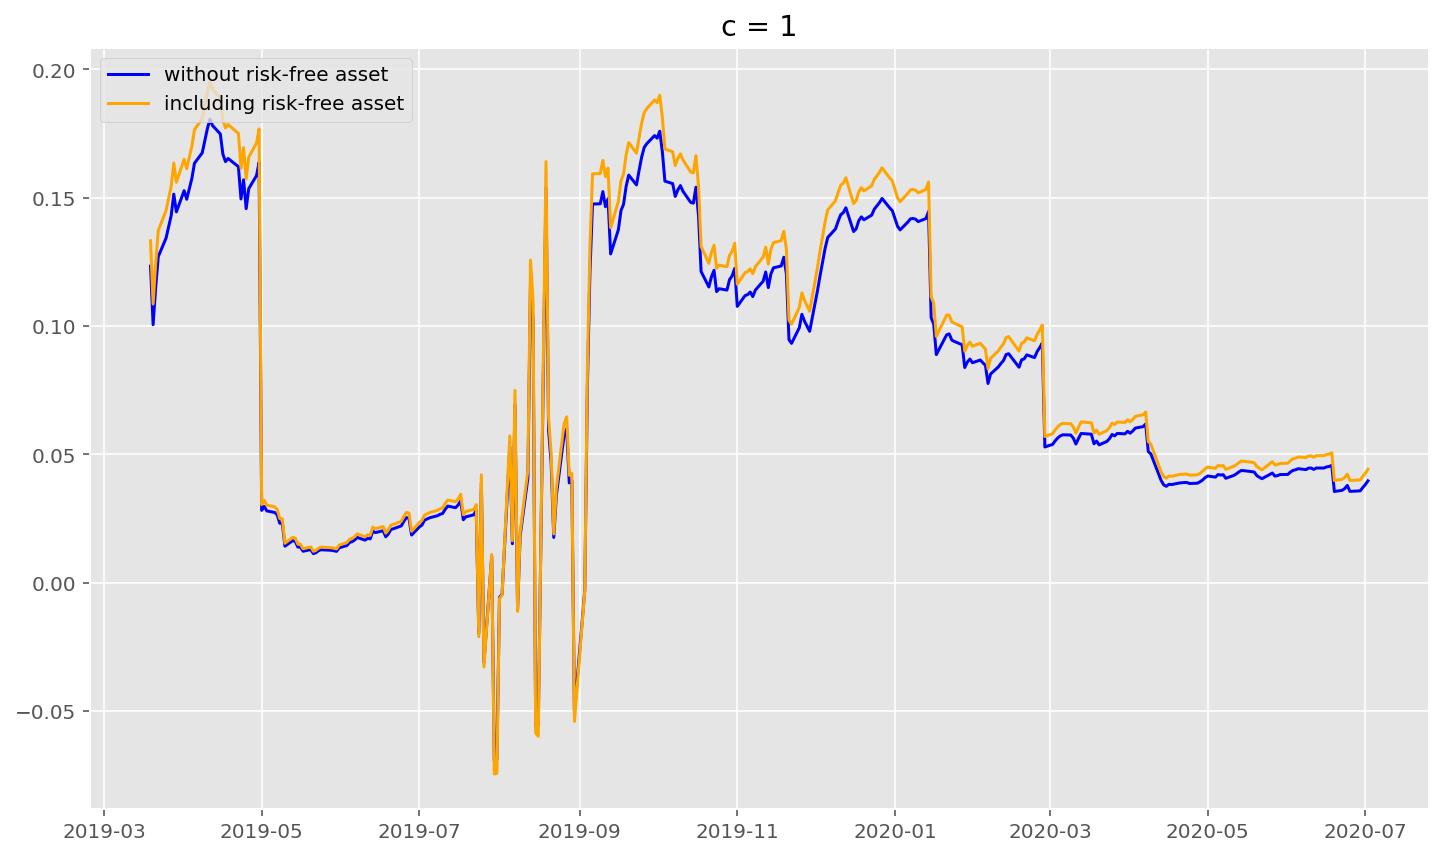

In [44]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
list_sr1 = list()
for i in range(len(risk_free)):
    sr1 = np.mean([np.dot(n, np.array(res_list[:-1][i])).T for n in np.array(montecarlo_mean[:-1][i])]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean[:-1][i])
    list_sr1.append(sr1)



list_sr2 = list()
for i in range(len(risk_free)):
    sr2 = np.mean(([np.dot(n, np.array(res_list2[i])).T for n in montecarlo_mean2[i]]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean2[i]))
    list_sr2.append(sr2)
    
ax.plot_date(dates, list_sr1, '-', color='blue', label='without risk-free asset')
ax.plot_date(dates, list_sr2, '-', color='orange', label='including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 1')
plt.show()

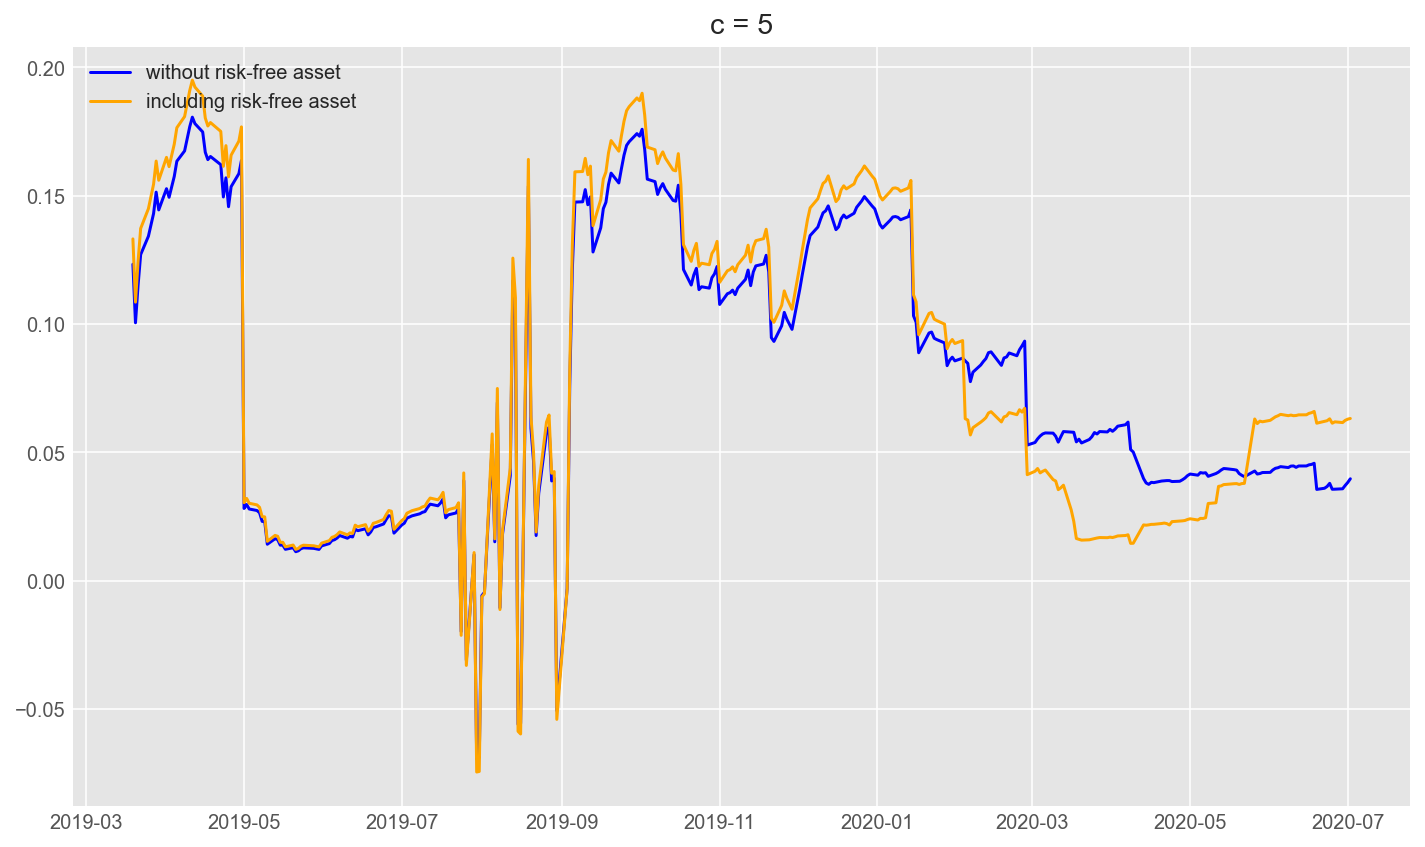

In [563]:
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
list_sr1 = list()
for i in range(len(risk_free)):
    sr1 = np.mean([np.dot(n, np.array(res_list[:-1][i])).T for n in np.array(montecarlo_mean[:-1][i])]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean[:-1][i])
    list_sr1.append(sr1)



list_sr2 = list()
for i in range(len(risk_free)):
    sr2 = np.mean(([np.dot(n, np.array(res_list2[i])).T for n in montecarlo_mean2[i]]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean2[i]))
    list_sr2.append(sr2)
    
ax.plot_date(dates, list_sr1, '-', color='blue', label='without risk-free asset')
ax.plot_date(dates, list_sr2, '-', color='orange', label='including risk-free asset')
plt.legend(loc="upper left")
ax.set_title('c = 5')
plt.show()

In [566]:
daily_retur1 = return_daily(real_return, res_list)
daily_retur2 = return_daily(return_with_rf, res_list2)
arr1 = np.array([[np.mean(daily_retur1), cumulative_returns1[-1], np.mean(list_vol1), np.mean(list_sr1)],
             [np.mean(daily_retur2), cumulative_returns2[-1], np.mean(list_vol2), np.mean(list_sr2)]])

pd.DataFrame(arr1, index = ['without risk-free', 'including risk-free'], 
             columns = ['Average daily return', 'Last value of cumulative return', 'Average of volatility', 'Average Sharpe ratio'])

Average daily return  Last value of cumulative return  \
without risk-free                0.001722                         1.658488   
including risk-free              0.000644                         1.185209   

                     Average of volatility  Average Sharpe ratio  
without risk-free                 0.000346              0.078140  
including risk-free               0.000202              0.079706

### Backtesting

In [46]:
var_list = list()
a = 0.05
for i in range(len(montecarlo_mean[:-1])):
    list_sim = list()
    for j in range(len(montecarlo_mean[:-1][i])):
        list_sim.append(np.dot(np.array(montecarlo_mean[:-1][i][j]).T, np.array(res_list[:-1][i])))
    var_list.append(np.quantile(list_sim, a))

In [47]:
rt_daily = return_daily(real_return, res_list)
sum(np.array(var_list) > np.array(rt_daily))/len(dates)

0.07951070336391437

In [459]:
dates[np.array(var_list) > np.array(rt_daily)]

DatetimeIndex(['2019-06-03', '2019-08-14', '2019-09-24', '2019-09-26',
               '2019-10-02', '2019-10-08', '2020-02-21', '2020-02-24',
               '2020-02-25', '2020-02-27', '2020-03-03', '2020-03-05',
               '2020-03-09', '2020-03-11', '2020-03-12', '2020-03-16',
               '2020-03-25', '2020-03-27', '2020-04-01', '2020-04-21',
               '2020-04-28', '2020-05-01', '2020-05-12', '2020-05-21',
               '2020-06-11', '2020-06-26'],
              dtype='datetime64[ns]', freq=None)

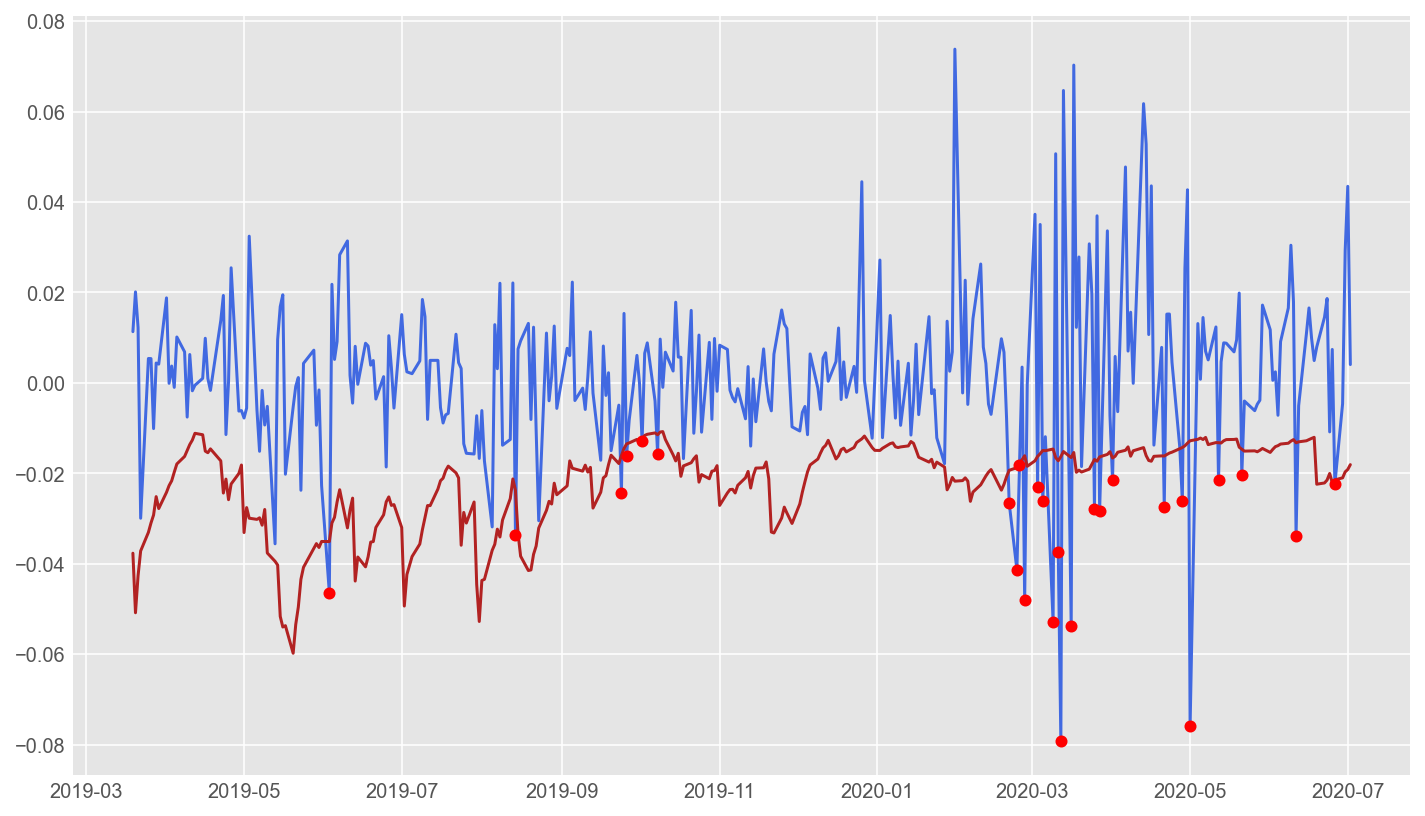

In [565]:
boolean_indices = [np.array(var_list) > np.array(rt_daily)][0]
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
ax.plot_date(dates, rt_daily, '-', color='royalblue')
ax.plot_date(dates, var_list, '-', color='firebrick')
ax.plot_date(dates[boolean_indices], np.array(rt_daily)[boolean_indices], '.', color='red', markersize=10)
plt.show()

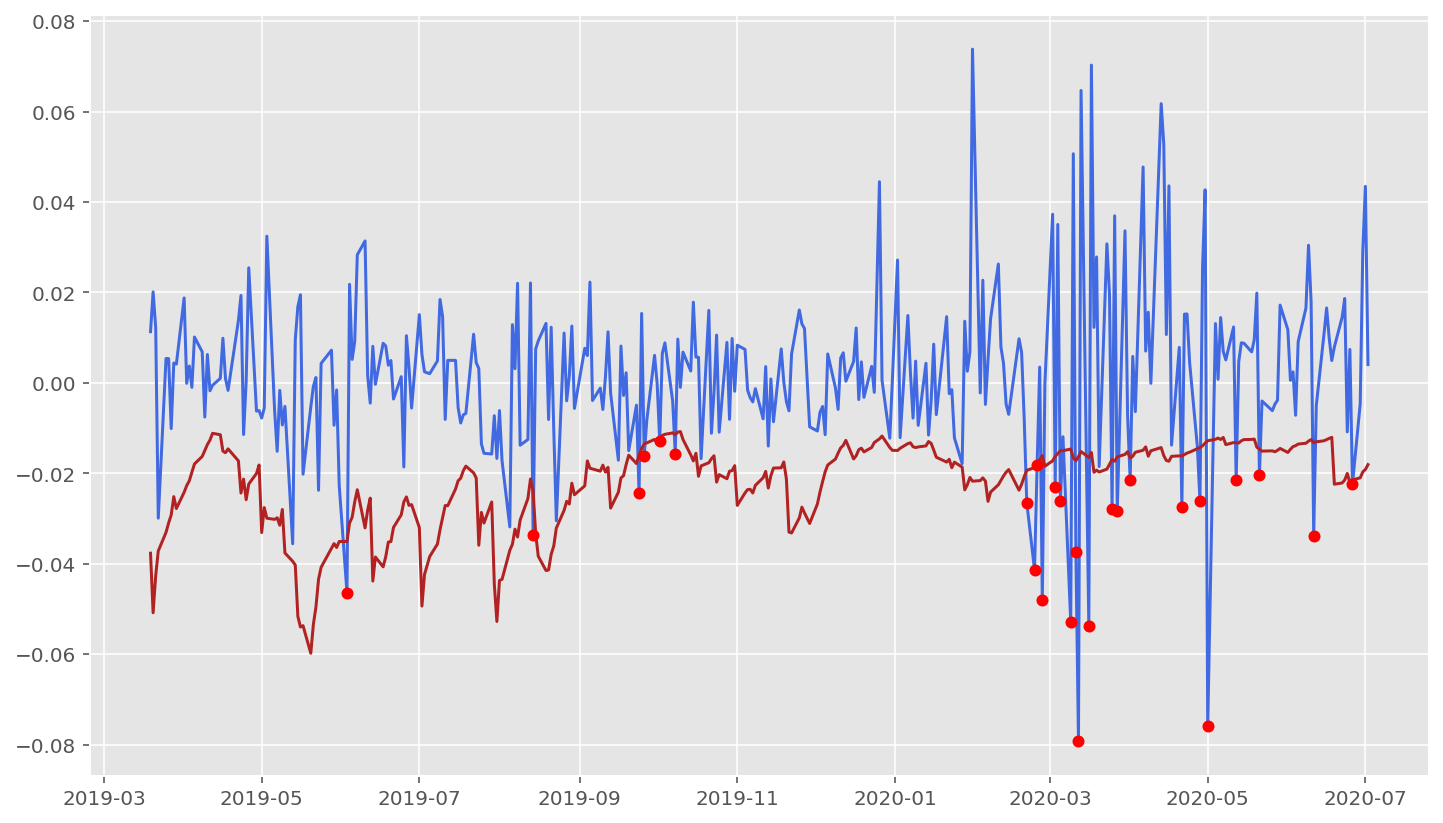

In [48]:
boolean_indices = [np.array(var_list) > np.array(rt_daily)][0]
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
ax.plot_date(dates, rt_daily, '-', color='royalblue')
ax.plot_date(dates, var_list, '-', color='firebrick')
ax.plot_date(dates[boolean_indices], np.array(rt_daily)[boolean_indices], '.', color='red', markersize=10)
plt.show()

In [461]:
str_dates = np.datetime_as_string(dates.values, unit='D')
str_dates[np.where(np.array(var_list) > np.array(rt_daily))]

array(['2019-06-03', '2019-08-14', '2019-09-24', '2019-09-26',
       '2019-10-02', '2019-10-08', '2020-02-21', '2020-02-24',
       '2020-02-25', '2020-02-27', '2020-03-03', '2020-03-05',
       '2020-03-09', '2020-03-11', '2020-03-12', '2020-03-16',
       '2020-03-25', '2020-03-27', '2020-04-01', '2020-04-21',
       '2020-04-28', '2020-05-01', '2020-05-12', '2020-05-21',
       '2020-06-11', '2020-06-26'], dtype='<U28')

### Mean return, volatility, Sharpe Ratio, VaR, IRR

## Mean-Variance portfolio with risk-free asset.

### Optimization task:

$$\underset{w_n}{Minimize} \frac{c}{2}w_n^T \Sigma w_n - w_n^T \mu_n - w_{n,0} R_{n,0} + \phi(w_n - w_{n-1})$$
s.t.$$1^T(w_n - w_{n-1}) + \phi(w_n - w_{n-1}) \leq 0 $$
where 
$$ \phi_i(x_i) = \left\{\begin{aligned} & = \alpha_i^+ x_i,  x \geq 0\\ & = - \alpha_i^- x_i,  x \leq 0  \end{aligned}\right.$$

In [29]:
c = 1
# w = np.repeat(1, covar1.shape[1])
w = np.array([.1, .1, .1, .1, .1, .1, .1])
a = 0.0015

In [30]:
def obj_func_init2(w, *args):
    args = list(args)
    covar = args[0]
    mean = args[1]
    rf = args[2]
    c = args[3]
    return (c/2 * np.dot(np.dot(w[:-1].T, covar), w[:-1]) - np.dot(w[:-1].T, mean)  - (w[-1] * rf) + fi(w))

In [31]:
def obj_func2(w, *args):
    args = list(args)
    w0 = args[0]
    covar = args[1]
    mean = args[2]
    rf = args[3]
    c = args[4]
    return (c/2 * np.dot(np.dot(w[:-1].T, covar), w[:-1]) - np.dot(w[:-1].T, mean) - (w[-1] * rf) * rf + fi(w - w0))

In [32]:
def con_init2(w):
    return (np.sum(w) - 1)


In [33]:
def con(w, w0):
    unity_vector = np.repeat(1, len(w))
    return (-(np.dot(unity_vector.T, w - w0) + fi(w - w0))) 

In [34]:
res_list2 = []
c = 1
for i in range(len(risk_free)):
    json1_covar = list(json_covar[i].values())
    covar = pd.DataFrame(json1_covar[:-1], index = json1_covar[-1], columns = json1_covar[-1])
    mean = np.array(list(json_mean[i].values()))
    rf = ((risk_free.iloc[i, 1])/100)/365
    
    if i == 0:
        w = np.array([.1, .1, .1, .1, .1, .1, .1])
        constraints_init2 = {'type': 'eq', 'fun': con_init2}
        res_list2.append(minimize(obj_func_init2, w, args = (covar, mean, rf, c), method="SLSQP", constraints=constraints_init2, bounds=Bounds(0, 1)).x)
    else:
        w = np.array([.1, .1, .1, .1, .1, .1, .1])
        w0 = res_list2[i - 1]
        constraints = {'type': 'eq', 'fun': con, 'args' : [w0]}
        constraints_init2 = {'type': 'eq', 'fun': con_init2}
        res_list2.append(minimize(obj_func2, w, args = (w0, covar, mean, rf, c), method="SLSQP", constraints=[constraints] , bounds=Bounds(0, 1)).x)

### Benchmarking.

### Daily returns. 

In [468]:
sum(res_list2[-1])

0.9999533855414374

In [35]:
# Adding to returns risk-free rate of return.
return_with_rf = np.zeros((risk_free.shape[0], len(real_return[0]) + 1))
for i in range(len(real_return)):
    return_with_rf[i,:] = np.append(real_return[i], ((risk_free.iloc[i,1]/100)/365))


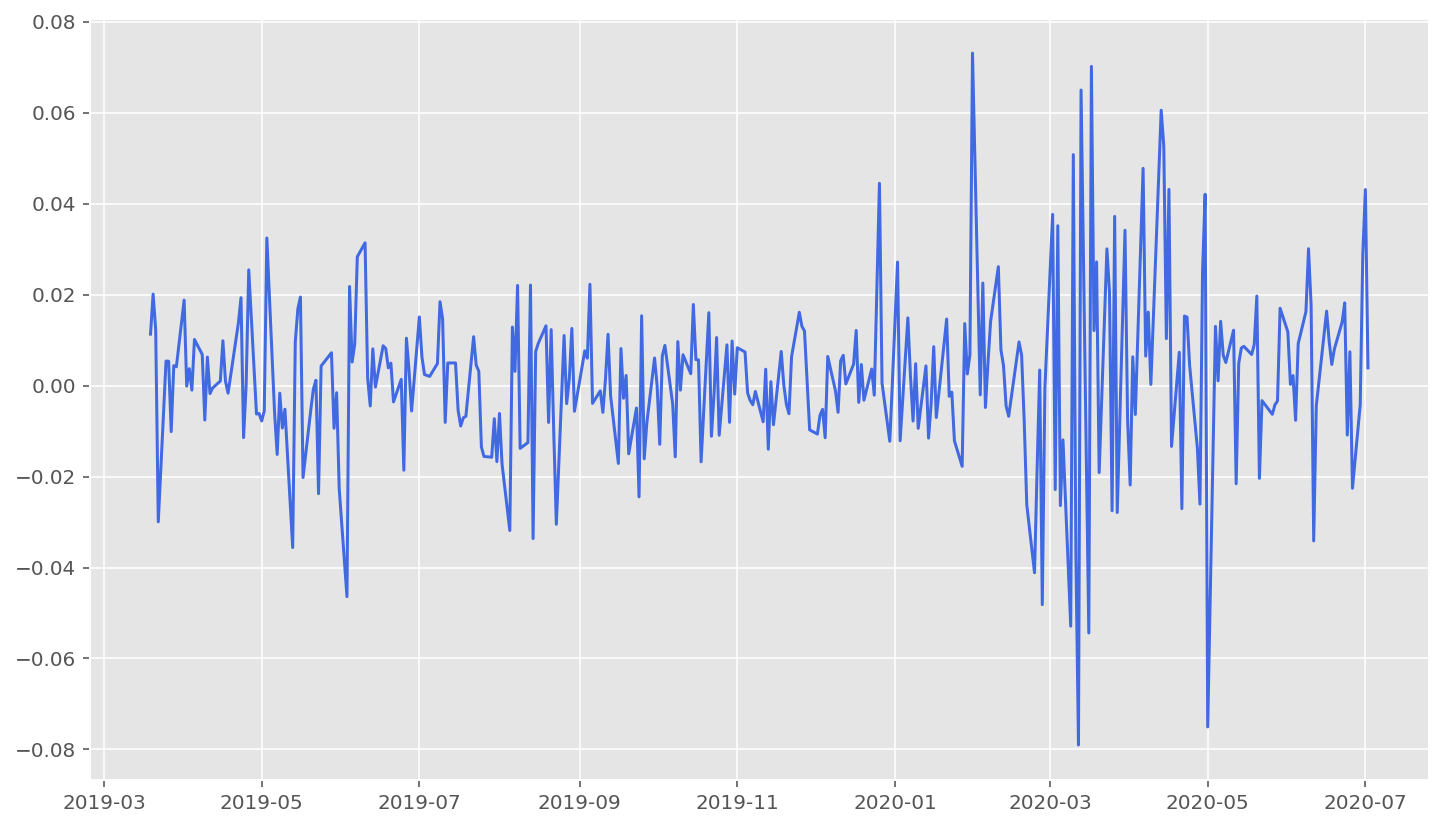

In [36]:
# Daily realized returns per each asset.

plt.figure(figsize=(12,7))
plt.plot_date(dates, return_daily(return_with_rf, res_list2), '-', color='royalblue')
plt.show()

In [471]:
np.mean(return_daily(return_with_rf, res_list2))

0.0017099791639029588

In [472]:
 np.mean(risk_free.iloc[:,1]/100)

0.014403975

### Graph of cumulative returns. 

In [37]:
plot_cumulative(return_with_rf, res_list2 )

NameError: name 'plot_cumulative' is not defined

### Graph of ex ante portfolio variance

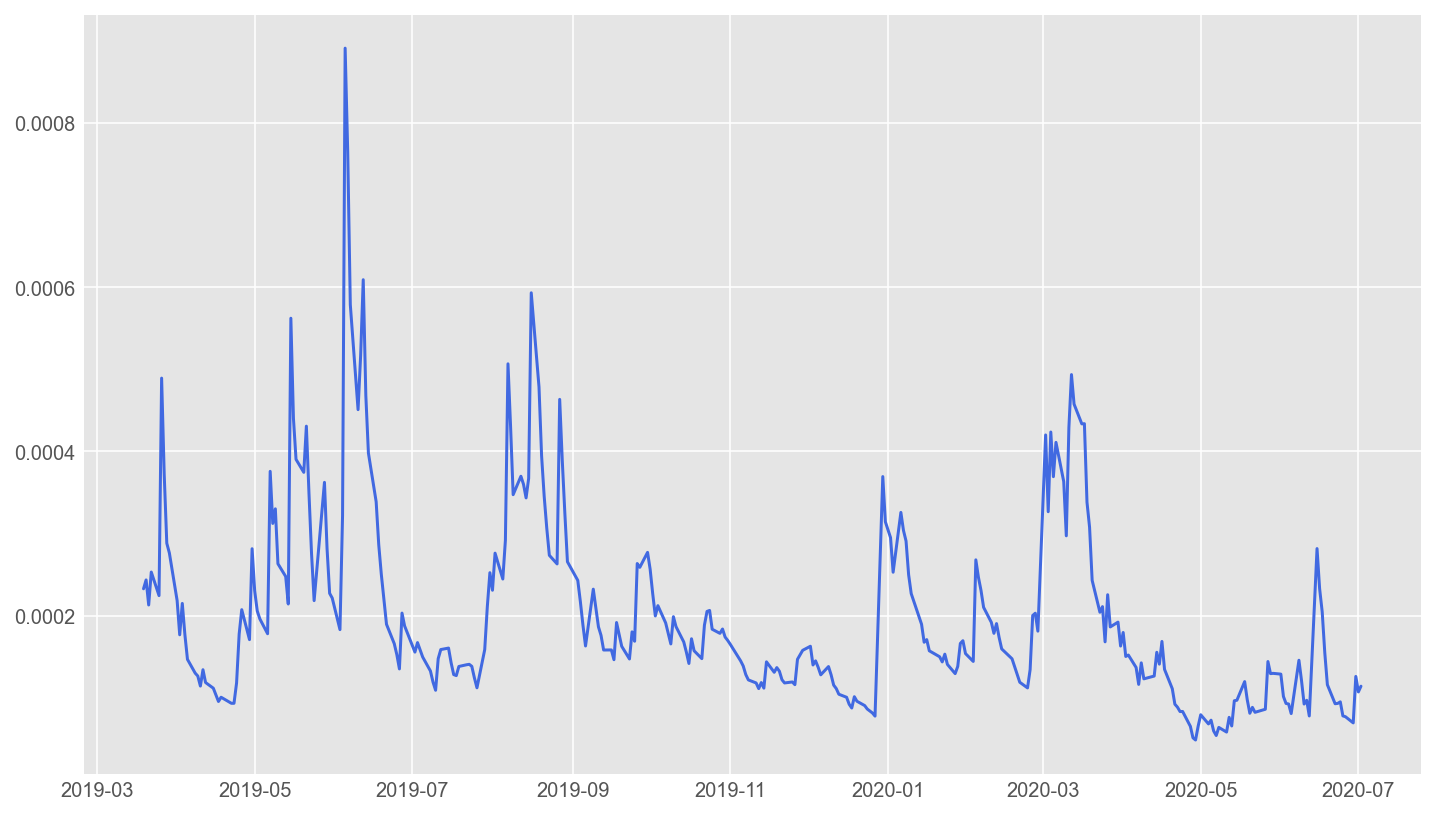

In [517]:
plot_vol(list_covar[:-1], [i[:-1] for i in res_list2])

In [475]:
[i[:-1] for i in res_list][1]

array([9.99991748e-01, 0.00000000e+00, 0.00000000e+00, 8.22701257e-06,
       5.55111512e-17])

### Graph of ex ante Sharpe ratio

$$SR = \frac{E[R_p^A - r_f^A]}{\sigma_p^A}$$

In [476]:
montecarlo_mean2 = list()
for i in range(len(montecarlo_mean) - 1):
    list_of_sim = list()
    for j in range(len(montecarlo_mean[0])):
            list_of_sim.append(montecarlo_mean[i][j] + [(risk_free.iloc[i,1]/100)/365])
    montecarlo_mean2.append(list_of_sim)

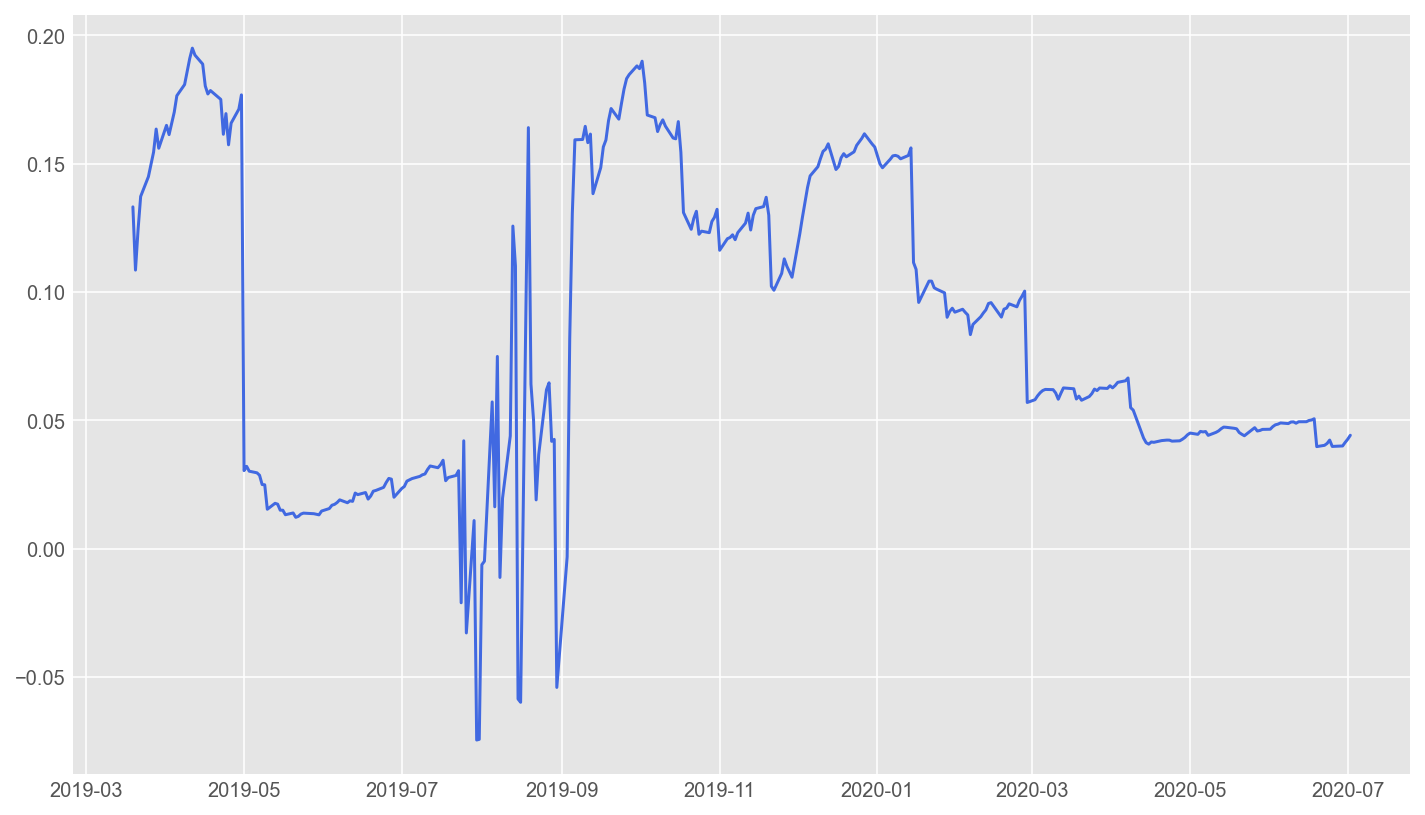

In [477]:
list_sr = list()
for i in range(len(risk_free)):
    sr = np.mean(([np.dot(n, np.array(res_list2[i])).T for n in montecarlo_mean2[i]]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean2[i]))
    list_sr.append(sr)
plt.style.use('ggplot')
plt.figure(figsize=(12,7))
plt.plot_date(dates, list_sr, '-', color='royalblue')
plt.show()

### Backtesting

In [478]:
var_list2 = list()
a = 0.05
for i in range(len(montecarlo_mean2)):
    list_sim = list()
    for j in range(len(montecarlo_mean2[i])):
        list_sim.append(np.dot(np.array(montecarlo_mean2[i][j]).T, np.array(res_list2[i])))
    var_list2.append(np.quantile(list_sim, a))

In [479]:
rt_daily2 = return_daily(return_with_rf, res_list2)
sum(np.array(var_list2) > np.array(rt_daily))/len(dates)

0.07951070336391437

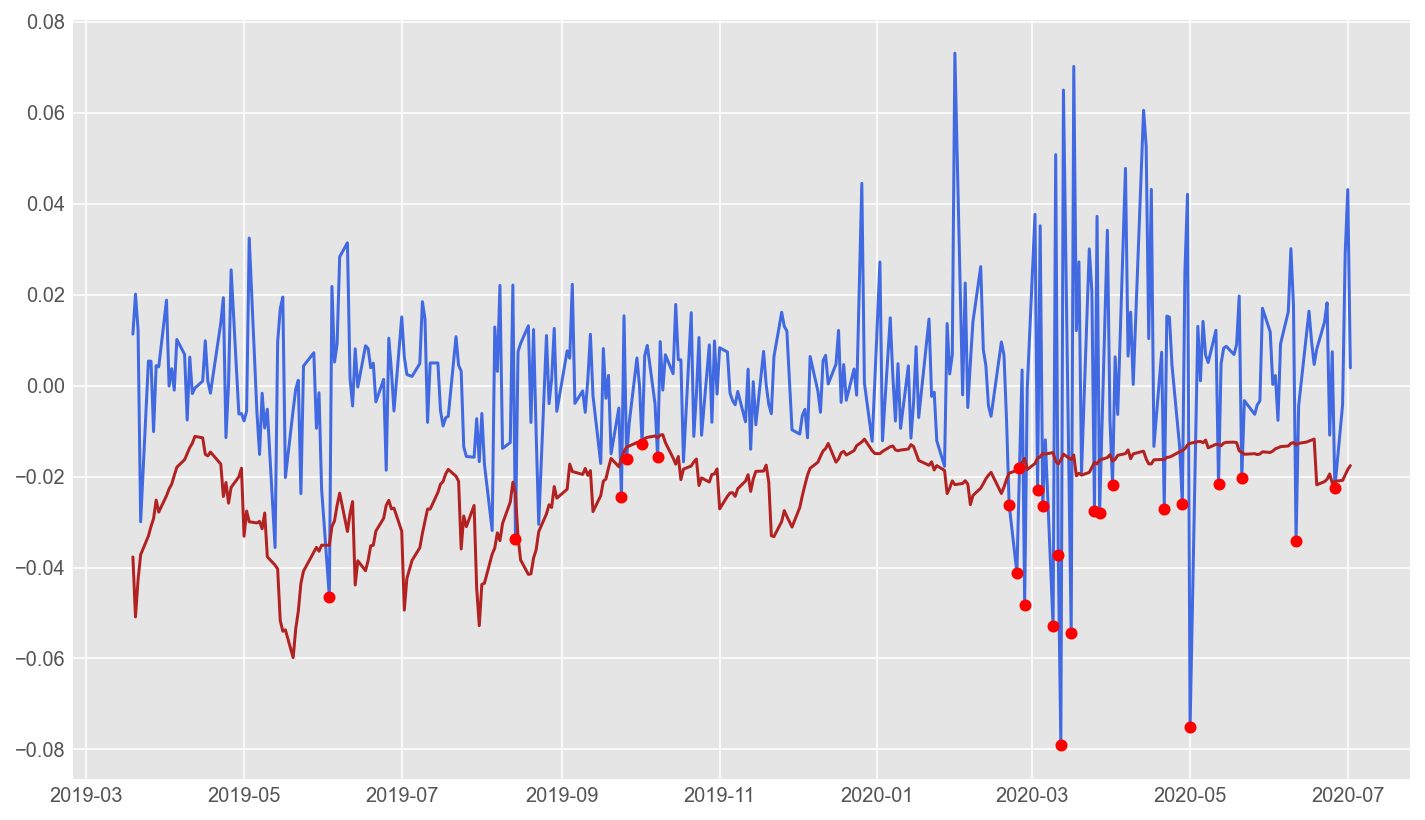

In [528]:
boolean_indices2 = [np.array(var_list2) > np.array(rt_daily2)][0]
fig, ax = plt.subplots(figsize=(12,7))
plt.style.use('ggplot')
ax.plot_date(dates, rt_daily2, '-', color='royalblue')
ax.plot_date(dates, var_list2, '-', color='firebrick')
ax.plot_date(dates[boolean_indices2], np.array(rt_daily2)[boolean_indices2], '.', color='red', markersize=10)
plt.show()

In [481]:
str_dates[(np.where(np.array(var_list2) > np.array(rt_daily2)))]

array(['2019-06-03', '2019-08-14', '2019-09-24', '2019-09-26',
       '2019-10-02', '2019-10-08', '2020-02-21', '2020-02-24',
       '2020-02-25', '2020-02-27', '2020-03-03', '2020-03-05',
       '2020-03-09', '2020-03-11', '2020-03-12', '2020-03-16',
       '2020-03-25', '2020-03-27', '2020-04-01', '2020-04-21',
       '2020-04-28', '2020-05-01', '2020-05-12', '2020-05-21',
       '2020-06-11', '2020-06-26'], dtype='<U28')

## Mean absolute deviation

### Optimization task:

$$\underset{w_n}{Minimize} \sum_{s=1}^{S}p_{n,s}|w_n^T(R_{n,s} - \bar{R_n})|$$
s.t. $$w_{0}R_0+w_n^T\bar{R_n} - \phi(w_n-w_{n-1}) \geq R_{min}$$
$$1^T(w_n - w_{n-1}) + \phi(w_n - w_{n-1}) \leq 0 $$
where 
$$ \phi_i(x_i) = \left\{\begin{aligned} & = \alpha_i^+ x_i,  x \geq 0\\ & = - \alpha_i^- x_i,  x \leq 0  \end{aligned}\right.$$

In [224]:
R_min = np.mean(return_daily(return_with_rf, res_list2))
# w = np.repeat(1, covar1.shape[1])
w = np.array([.1, .1, .1, .1, .1, .1, .1])
rf = ((risk_free.iloc[i, 1])/100)/365
pn = 1/len(montecarlo_mean[0])

In [225]:
def obj_func3(w, pn, montecarlo_mean):
    for_sum = np.zeros((len(montecarlo_mean), len(w) - 1))
    i = 0
    for mean in montecarlo_mean:
        for_sum[i,:] = (pn * np.abs(mean - np.mean(montecarlo_mean, axis=0)))
        i += 1
    return np.sum(np.dot(for_sum, w[:-1].T))

In [226]:
%%time
obj_func3(w, pn, montecarlo_mean[0])

CPU times: user 28.2 ms, sys: 1.63 ms, total: 29.9 ms
Wall time: 28.6 ms


0.008674526639500002

In [227]:
def con_init3(w):
    return (np.sum(w) - 1)


In [228]:
def con3_1(w, w0, montecarlo_mean, rf):
    return (w[-1] * rf + np.dot(w[:-1], np.mean(montecarlo_mean, axis=0)) - fi(w - w0) - R_min)

In [229]:
con3_2(res_list3[10], res_list3[9])

-2.324569465070314e-09

In [230]:
def con3_2(w, w0):
    unity_vector = np.repeat(1, len(w))
    return (-(np.dot(unity_vector.T, w - w0) + fi(w - w0))) 

In [231]:
%%time
res_list3 = []
for i in range(len(risk_free)):
    mean = np.array(list(json_mean[i].values()))
    montecarlo = montecarlo_mean[i]
    pn = 1/len(montecarlo_mean)
    rf = ((risk_free.iloc[i, 1])/100)/365
    
    if i == 0:
        w = np.array([.1, .1, .1, .1, .1, .1, .1])
        constraints_init3 = {'type': 'eq', 'fun': con_init3}
        res_list3.append(minimize(obj_func3, w, args = (pn, montecarlo), constraints=[constraints_init3], bounds=Bounds(0, 1)).x)
    else:
        w = np.array([.1, .1, .1, .1, .1, .1, .1])
        w0 = res_list3[i - 1]
        constraints3_1 = {'type': 'ineq', 'fun': con3_1, "args" : [w0, montecarlo, rf]}
        constraints3_2 = {'type': 'ineq', 'fun': con3_2, "args" : [w0]}
        res_list3.append(minimize(obj_func3, w, args = (pn, montecarlo), constraints=[constraints3_1, constraints3_2], bounds=Bounds(0, 1)).x)

CPU times: user 48min 40s, sys: 23.4 s, total: 49min 3s
Wall time: 49min 8s


In [250]:
np.mean(return_daily(return_with_rf, res_list3))

0.0001550889491157366

In [251]:
R_min

0.001723094007799764

### Benchmarking.

### Daily returns. 

In [238]:
# Adding to returns risk-free rate of return.
return_with_rf = np.zeros((risk_free.shape[0], len(real_return[0]) + 1))
for i in range(len(real_return)):
    return_with_rf[i,:] = np.append(real_return[i], ((risk_free.iloc[i,1]/100)/365))


In [239]:
sum(res_list3[4])

0.16141411464490857

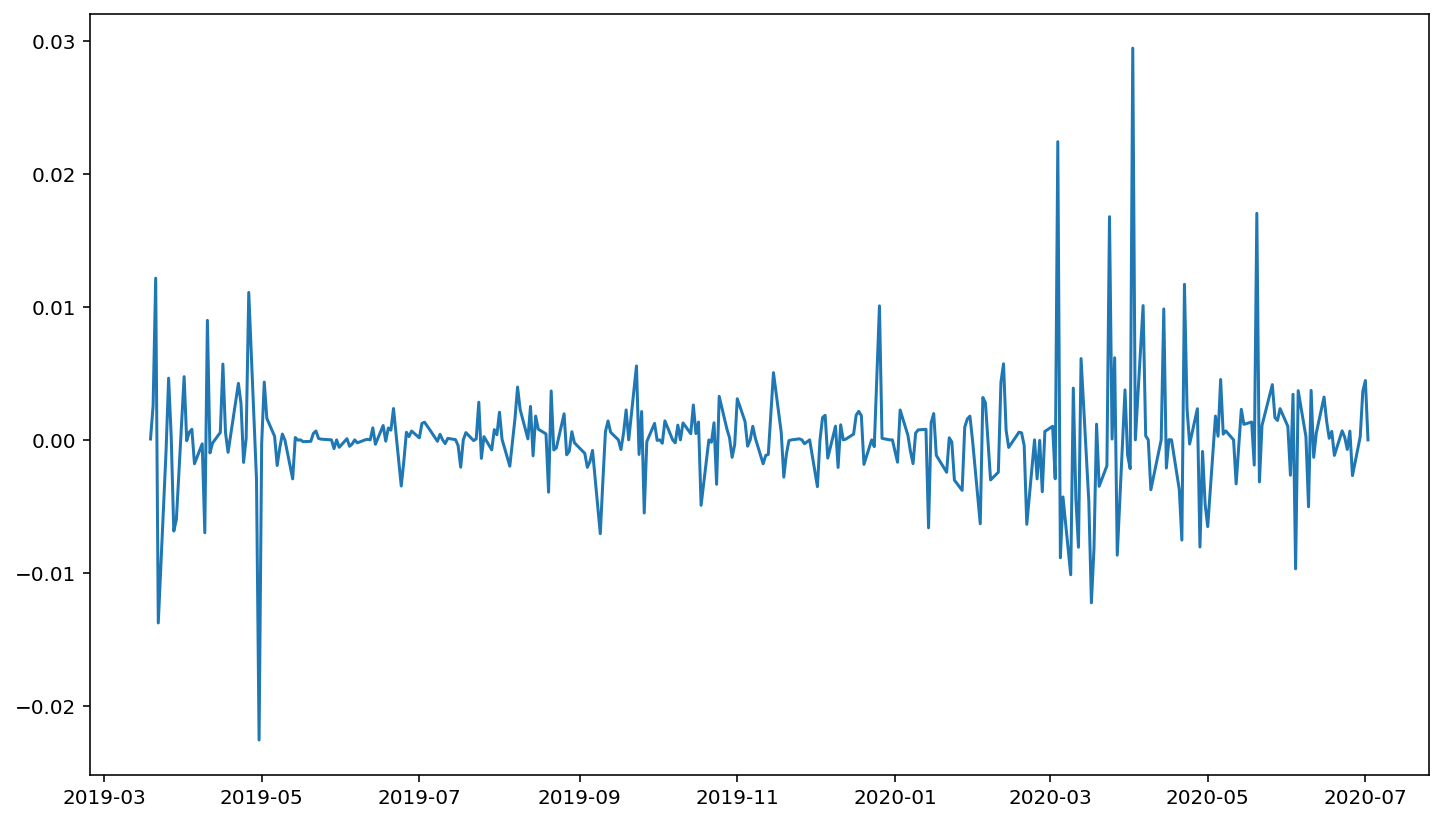

In [240]:
# Daily realized returns per each asset.

plt.figure(figsize=(12,7))
plt.plot_date(dates, return_daily(return_with_rf, res_list3), '-')
plt.show()

### Graph of cumulative returns. 

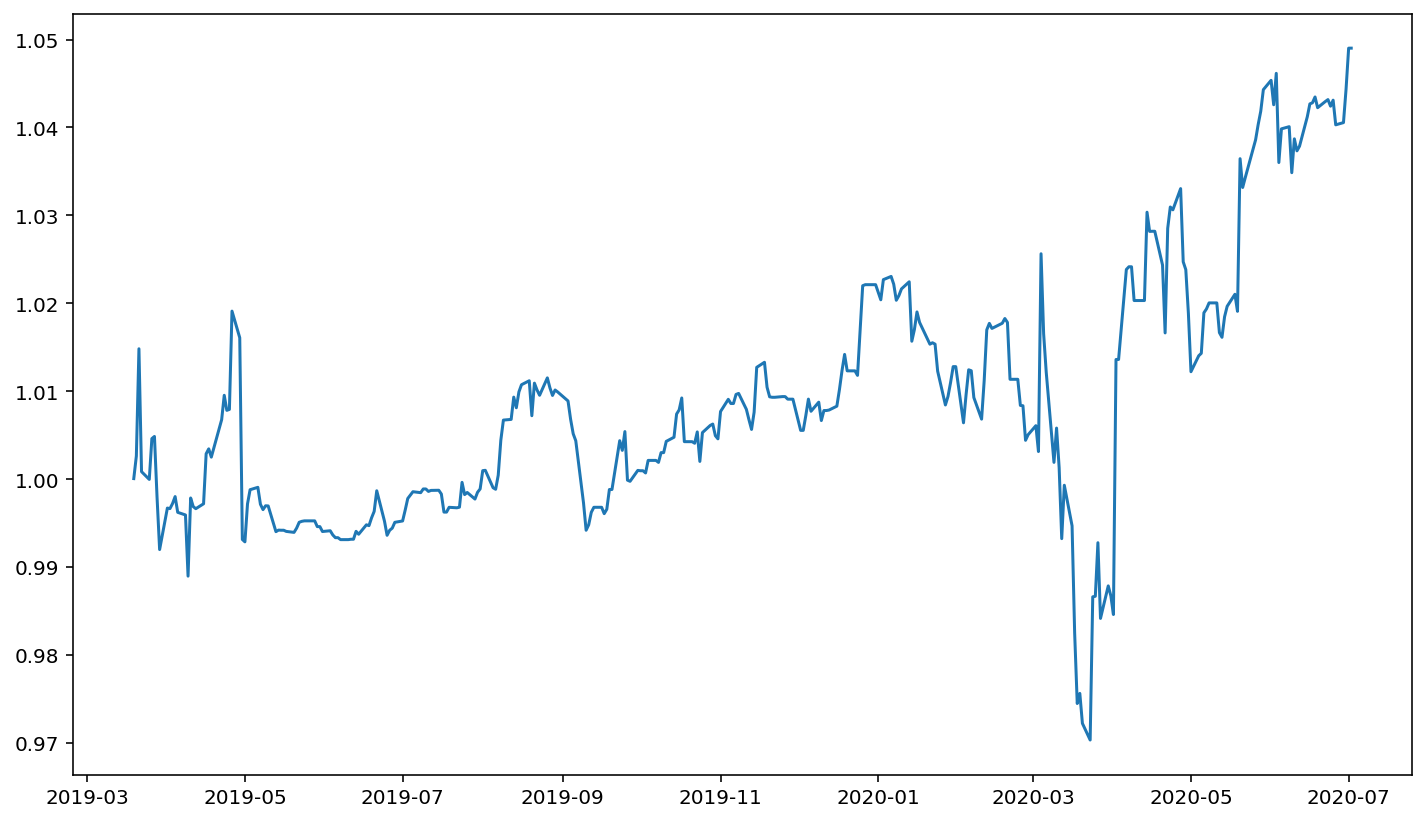

In [241]:
plot_cumulative(return_with_rf, res_list3)

### Graph of ex ante portfolio variance

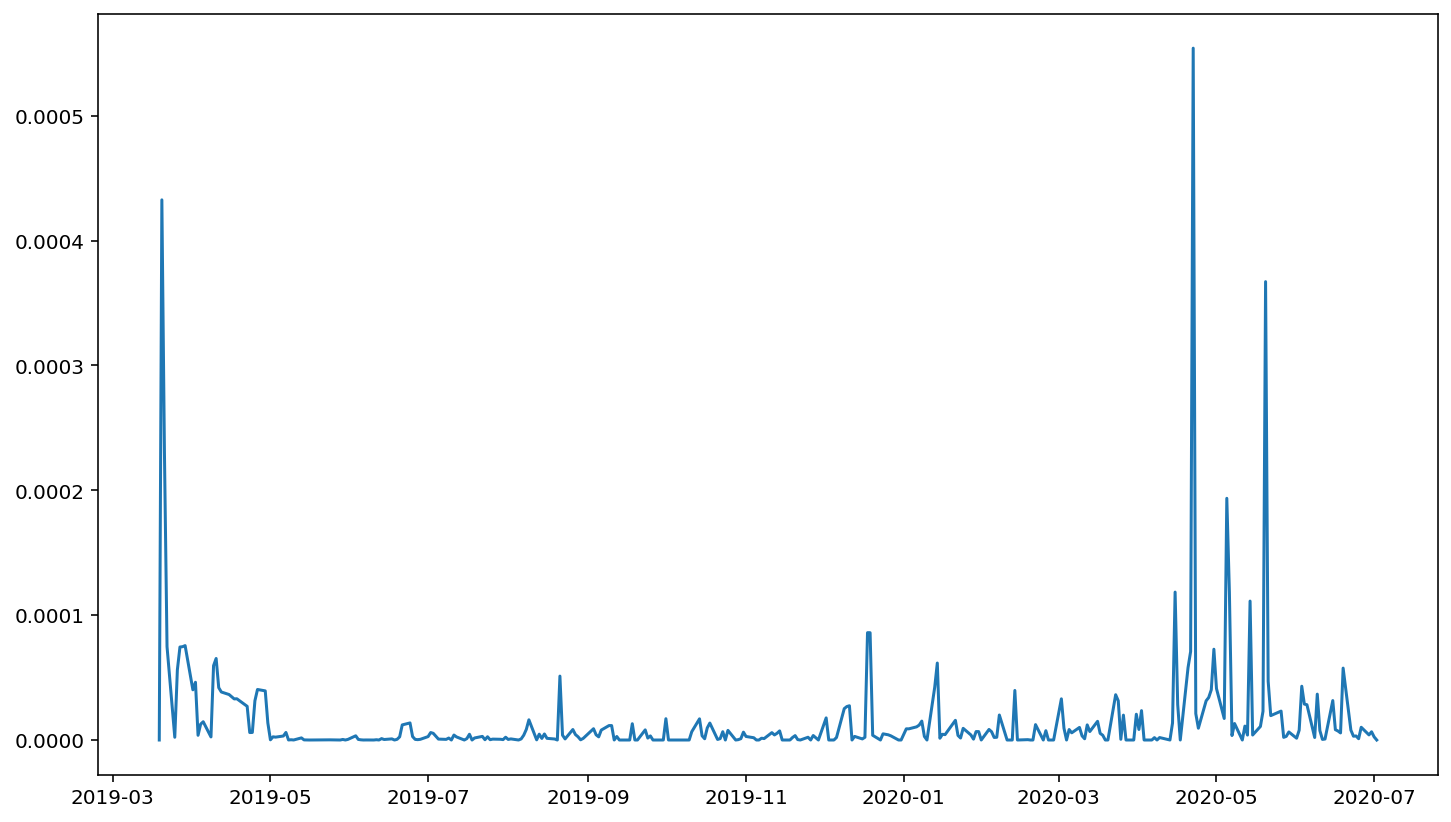

In [242]:
plot_vol(list_covar[:-1], [i[:-1] for i in res_list3])

In [ ]:
[i[:-1] for i in res_list][1]

### Graph of ex ante Sharpe ratio

$$SR = \frac{E[R_p^A - r_f^A]}{\sigma_p^A}$$

In [43]:
montecarlo_mean2 = list()
for i in range(len(montecarlo_mean) - 1):
    list_of_sim = list()
    for j in range(len(montecarlo_mean[0])):
            list_of_sim.append(montecarlo_mean[i][j] + [(risk_free.iloc[i,1]/100)/365])
    montecarlo_mean2.append(list_of_sim)

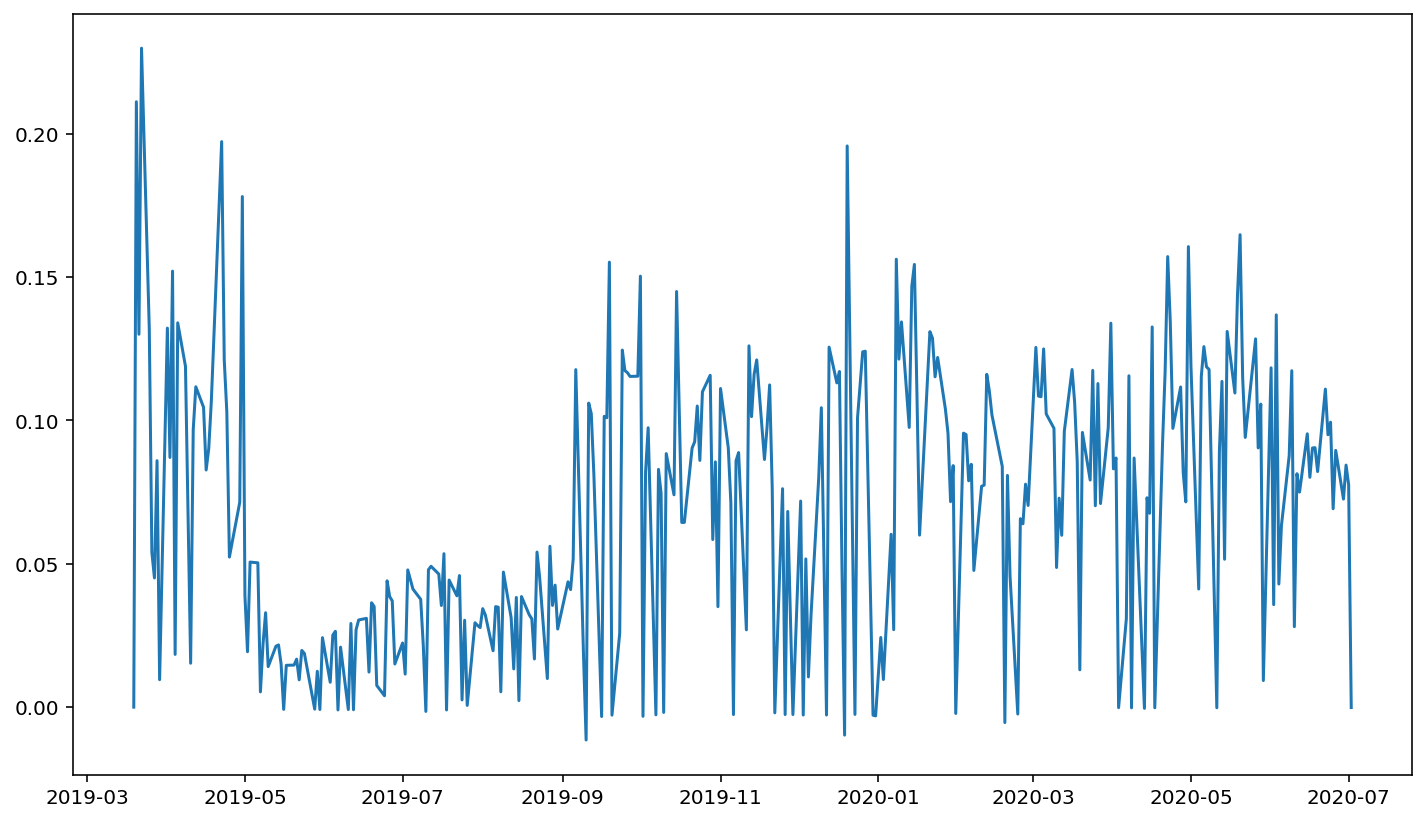

In [245]:
list_sr = list()
for i in range(len(risk_free)):
    sr = np.mean(([np.dot(n, np.array(res_list3[i])).T for n in montecarlo_mean2[i]]
                    - ((risk_free.iloc[i, 1])/100)/365)/np.std(montecarlo_mean2[i]))
    list_sr.append(sr)
plt.figure(figsize=(12,7))
plt.plot_date(dates, list_sr, '-')
plt.show()

### Backtesting

In [246]:
var_list3 = list()
a = 0.05
for i in range(len(montecarlo_mean2)):
    list_sim = list()
    for j in range(len(montecarlo_mean2[i])):
        list_sim.append(np.dot(np.array(montecarlo_mean2[i][j]).T, np.array(res_list3[i])))
    var_list3.append(np.quantile(list_sim, a))

In [247]:
rt_daily3 = return_daily(return_with_rf, res_list3)
sum(np.array(var_list3) > np.array(rt_daily3))/len(dates)

0.24770642201834864

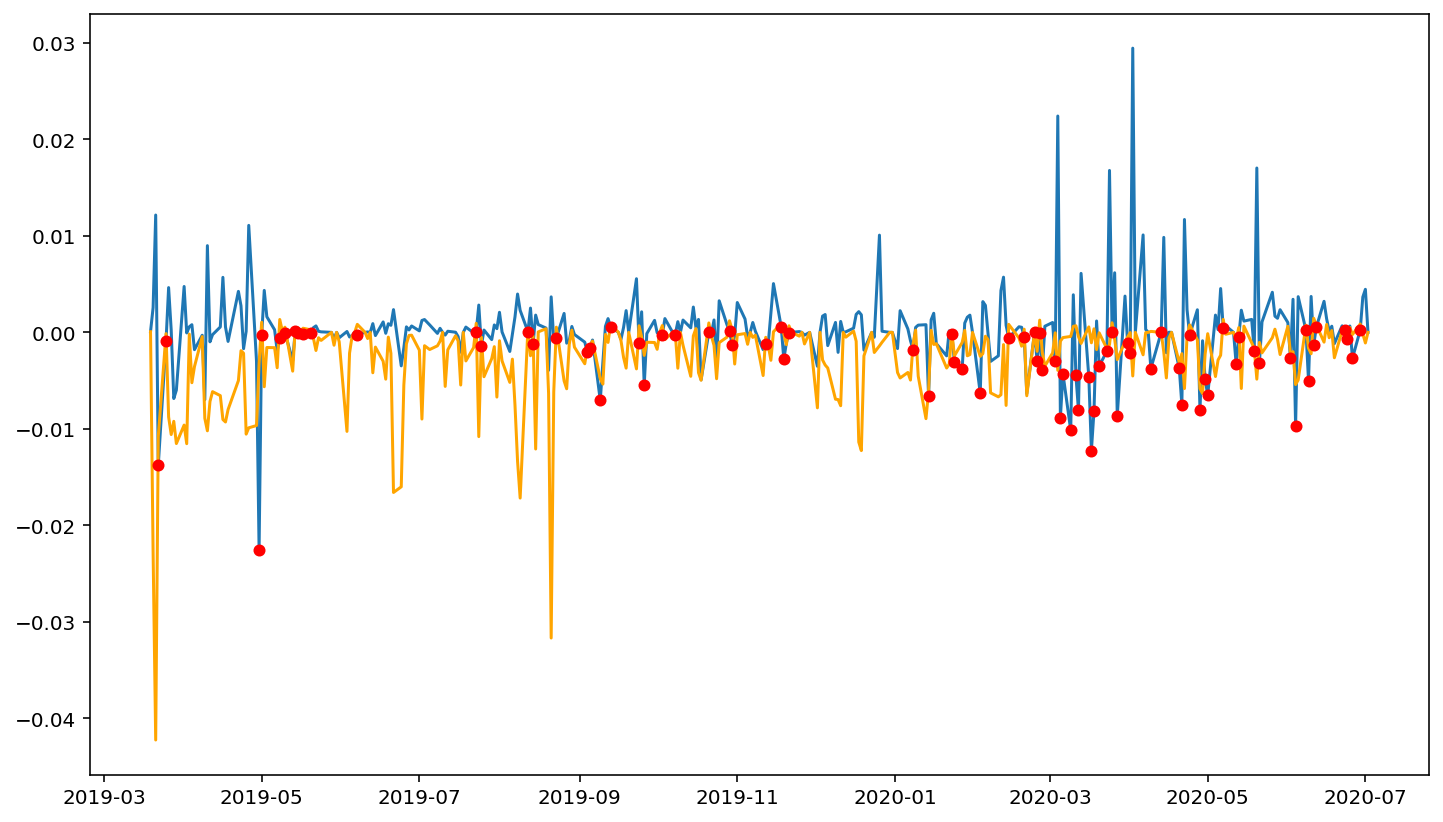

In [248]:
boolean_indices3 = [np.array(var_list3) > np.array(rt_daily3)][0]
fig, ax = plt.subplots(figsize=(12,7))
ax.plot_date(dates, rt_daily3, '-')
ax.plot_date(dates, var_list3, '-', color='orange')
ax.plot_date(dates[boolean_indices3], np.array(rt_daily3)[boolean_indices3], '.', color='red', markersize=10)
plt.show()

In [ ]:
str_dates[(np.where(np.array(var_list3) > np.array(rt_daily3)))]